# Hotel Booking Demand
### Dibuat oleh : Daffa Dzaky Naufal

## Business Understanding Problem

**Context** <br>
Industri hotel menghadapi tantangan konstan dalam mengelola pembatalan, yang dapat berdampak signifikan terhadap pendapatan dan operasional. Dengan menganalisis data pemesanan, hotel dapat mengidentifikasi pola yang berkontribusi terhadap pembatalan dan membuat keputusan berdasarkan data untuk meminimalkannya. Kumpulan data ini berisi informasi pemesanan untuk sebuah hotel di Portugal dan mencakup rincian tentang pemesanan, perilaku pelanggan, dan pembatalan.

Target:<br>
0 : Tidak membatalkan *booking*<br>
1 : Membatalkan *booking*


**Problem Statement**<br>
Hotel mengalami tingkat pembatalan pemesanan yang tinggi, yang menyebabkan kerugian finansial, sumber daya yang kurang dimanfaatkan, dan inefisiensi operasional. Sangatlah penting untuk memahami faktor-faktor yang berkontribusi terhadap pembatalan dan mengidentifikasi pelanggan yang cenderung membatalkan pemesanan mereka.

**Goals**<br>
Berdasarkan permasalahan tersebut, perusahaan ingin dapat memprediksi apakah pemesanan akan dibatalkan berdasarkan pelanggan dan fitur pemesanan. Selain itu, perusahaan juga ingin mengidentifikasi faktor-faktor utama yang memengaruhi pembatalan untuk memungkinkan strategi bisnis yang lebih baik, serta mengembangkan wawasan yang dapat ditindaklanjuti untuk mengurangi tingkat pembatalan, meningkatkan perencanaan operasional, dan meningkatkan pengalaman pelanggan.

**Analytic Approach**<br>
Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan tamu hotel yang tidak membatalkan *booking* dan yang membatalkan *booking*.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang tamu hotel akan membatalkan *booking* atau tidak.

**Metric Evaluation**<br>
1. False Positive (FP)<br>
    Potensi Biaya
    1. Manajemen Pemesanan Lebih:
        - Hotel dapat menerima reservasi cadangan atau mempersiapkan overbooking untuk mengantisipasi pembatalan.
        - Jika tamu asli datang, hotel mungkin perlu memberikan kompensasi kepada pelanggan cadangan atau menyediakan akomodasi alternatif.
    2. Dampak terhadap Pengalaman Pelanggan:
        - Ketidakefisienan operasional (misalnya, pemesanan ganda) dapat menyebabkan ulasan pelanggan yang buruk, yang secara tidak langsung memengaruhi pemesanan di masa mendatang.<br>
    
    Perhitungan Biaya:
    - Tarif Kamar Dasar: €120
    - Biaya Peluang: 30% × €120 = €36
    - Gangguan Operasional: €25
    - Kompensasi Tamu: €50
    - Total Biaya FP: €211

2. False Negative (FN)
    Potensi Biaya
    1. Pendapatan yang Hilang:
        - Jika kamar tetap kosong karena pembatalan, hotel akan kehilangan potensi pendapatan dari kamar tersebut.
    2. Ketidakefisienan Operasional:
        - Staf atau sumber daya yang tidak terpakai yang dialokasikan untuk pemesanan yang dibatalkan.
    3. Kerusakan Reputasi:
        - Pembatalan yang sering terjadi tanpa strategi proaktif dapat merusak reputasi hotel, sehingga mengurangi bisnis yang berulang.<br>
    
    Perhitungan Biaya:
    - Pendapatan Kamar yang Hilang: €180
    - Layanan Tambahan yang Terlewatkan: 40% × €180 = €72
    - Biaya Peluang: 50% × €180 = €90
    - Perkiraan Kerusakan Reputasi: €100
    - Total Biaya FN: €442

Berdasarkan perkiraan biaya di atas, dapat disimpulkan bahwasannya FN memiliki kerugian yang lebih besar dibandingkan FP. Oleh karena itu, metric yang digunakan pada model kali ini adalah Recall (Fokus pada pengurangan nilai FN).

## Data Understanding

Dataset ini mengandung informasi mengenai tamu hotel yang melakukan pemesanan di Hotel. *Features* yang terdapat yaitu:
- country: Negara asal.
- market_segment: Penunjukan segmen pasar. 
- previous_cancellations: Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini.
- booking_changes: Jumlah perubahan/perubahan yang dilakukan pada pemesanan dari saat pemesanan dimasukkan pada PMS hingga saat check-in atau pembatalan.
- deposit_type: Indikasi apakah pelanggan melakukan deposit untuk menjamin pemesanan. 
- days_in_waiting_list: Jumlah hari pemesanan berada dalam daftar tunggu sebelum dikonfirmasi kepada pelanggan.
- customer_type: Jenis pemesanan.
- reserved_room_type: Kode jenis kamar yang dipesan. Kode ditampilkan sebagai pengganti nama untuk alasan anonimitas.
- required_car_parking_space: Jumlah ruang parkir mobil yang dibutuhkan oleh pelanggan.
- total_of_special_request: Jumlah permintaan khusus yang diajukan oleh pelanggan (misalnya tempat tidur kembar atau lantai yang lebih tinggi).
- is_canceled: Nilai yang menunjukkan apakah pemesanan dibatalkan (1) atau tidak (0).

In [3]:
# Library

import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import dtale

# Feature Engineering
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from hyperopt import hp, tpe, Trials, STATUS_OK, space_eval, fmin, STATUS_FAIL
from hyperopt.pyll import scope

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
if not hasattr(np, "VisibleDeprecationWarning"):
    class VisibleDeprecationWarning(Warning):
        pass
    np.VisibleDeprecationWarning = VisibleDeprecationWarning
warnings.filterwarnings('ignore', category=UserWarning)
import logging
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='Using categorical units to plot a list of strings')

# Suppress specific logging messages
logging.getLogger('matplotlib.category').setLevel(logging.ERROR)

# Set max columns
pd.set_option('display.max_columns', None)

## 1. Load Dataset

In [4]:
#Load Dataset
df = pd.read_csv("data_hotel_booking_demand.csv")
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [6]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [7]:
df.describe(include='object')

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


## 2. Exploratory Data Analysis (EDA)

EDA dilakukan dengan menggunakan module SweetViz dan D-Tale. Pada notebook ini, Sweetviz digunakan untuk melakukan EDA otomatis sedangkan D-Tale digunakan untuk melihat outlier dan persebaran target di setiap kolom.

In [8]:
my_report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)


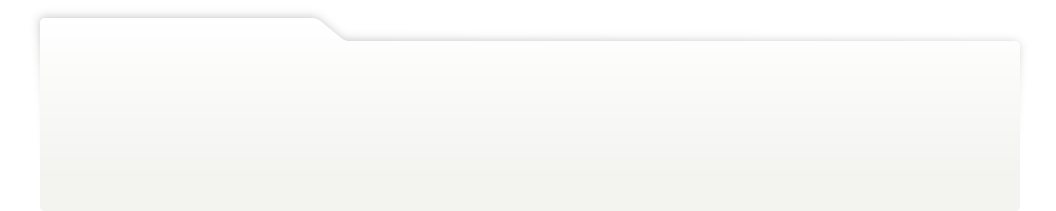
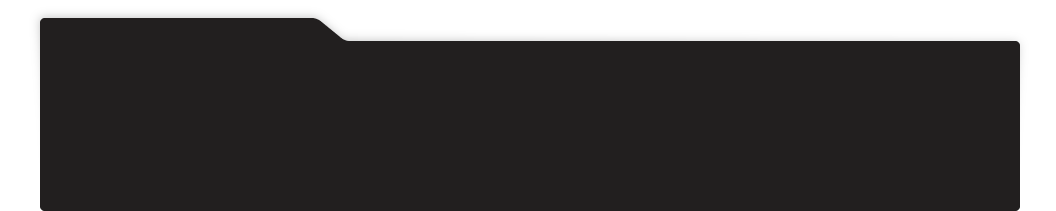
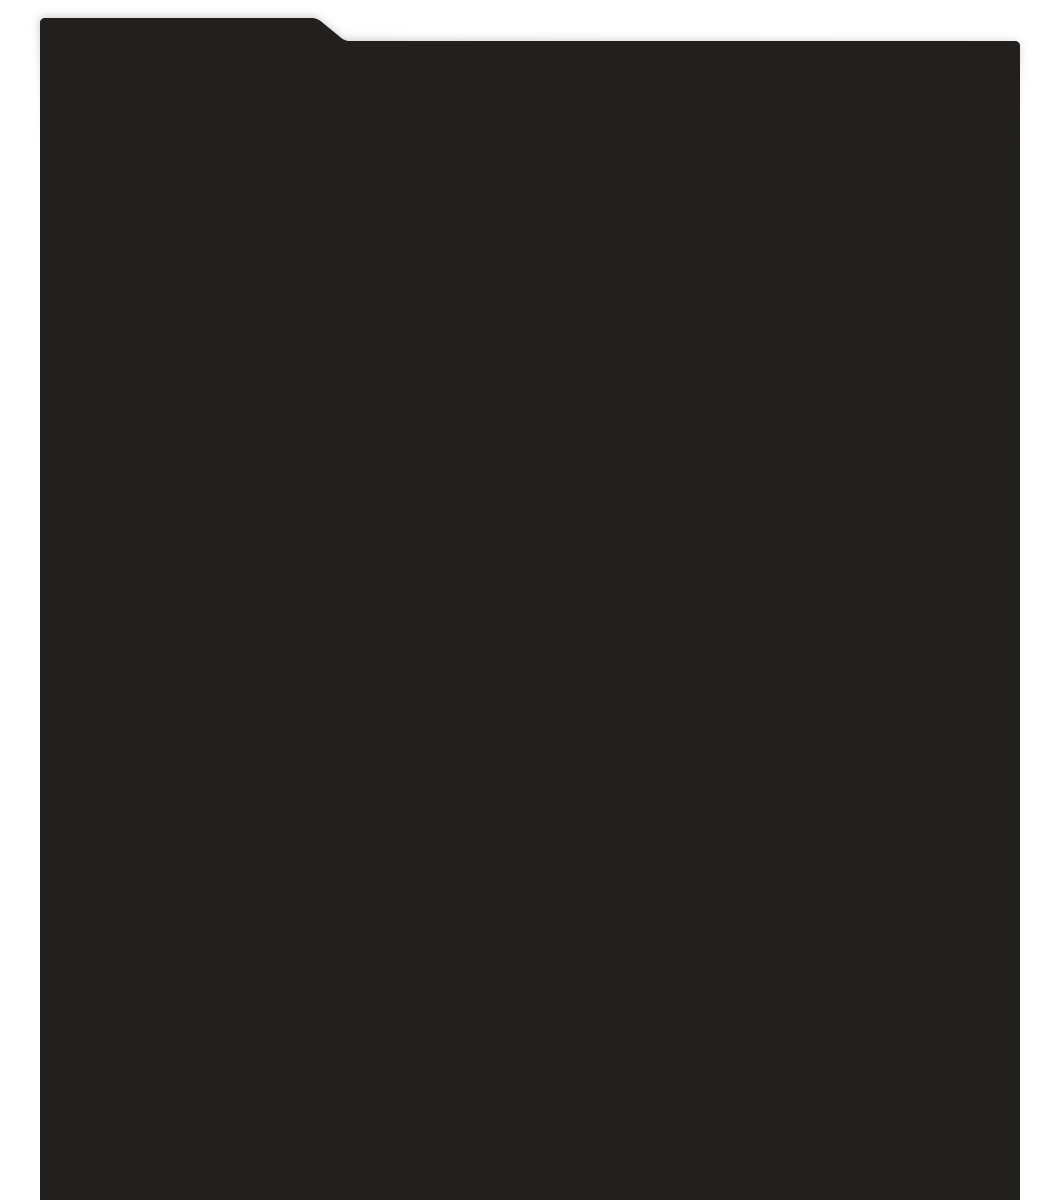
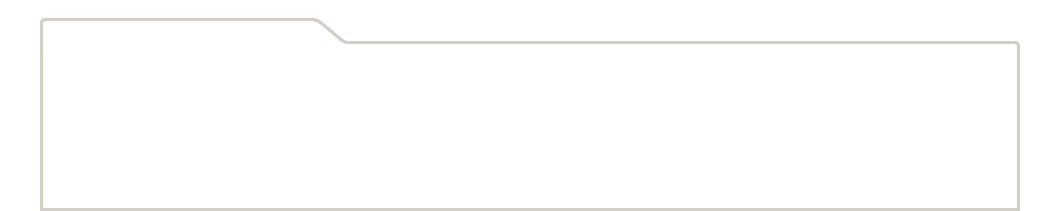
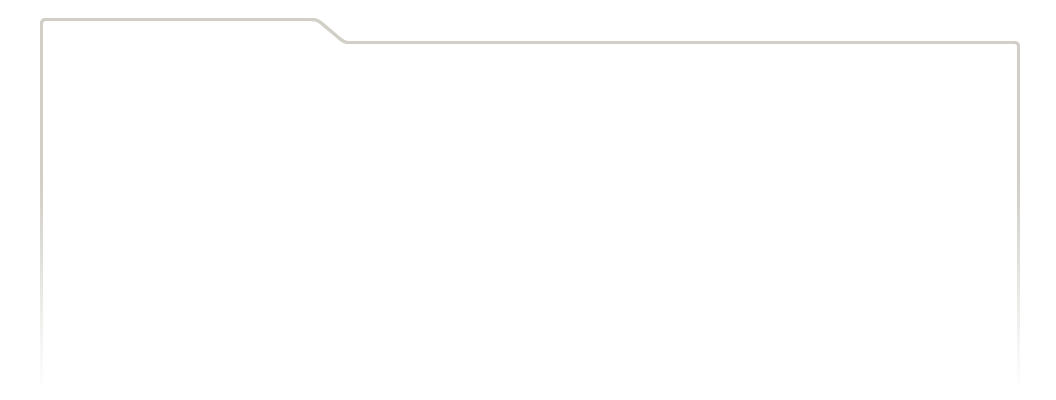
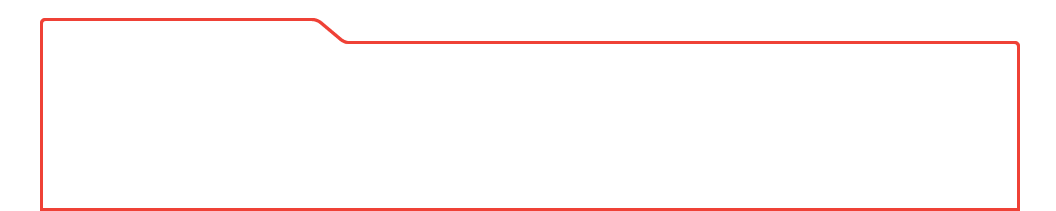
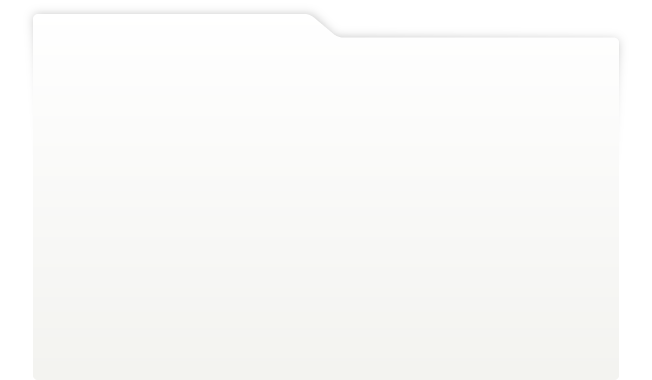
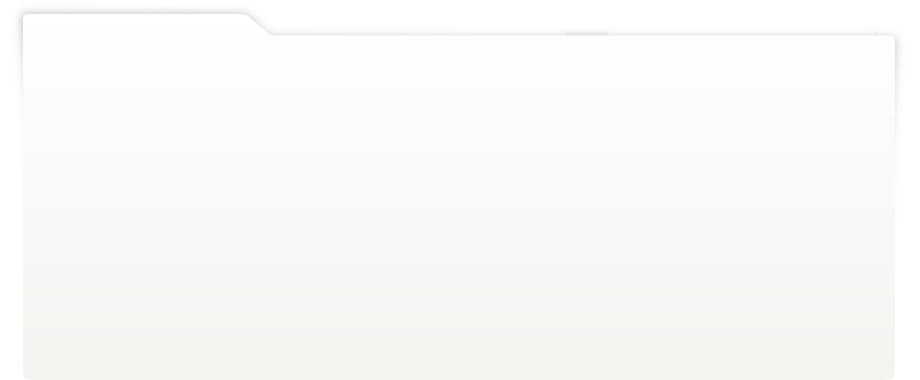
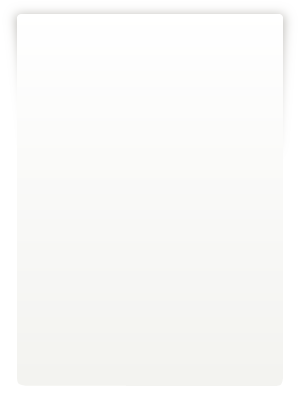
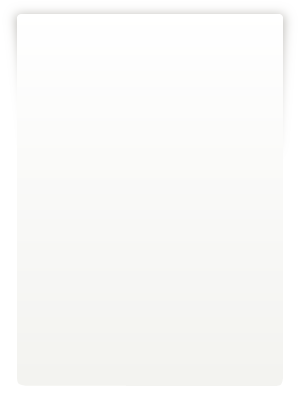
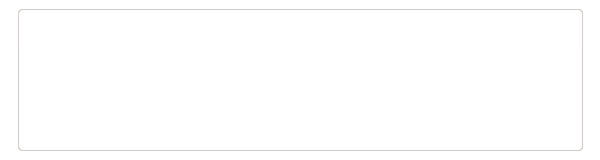
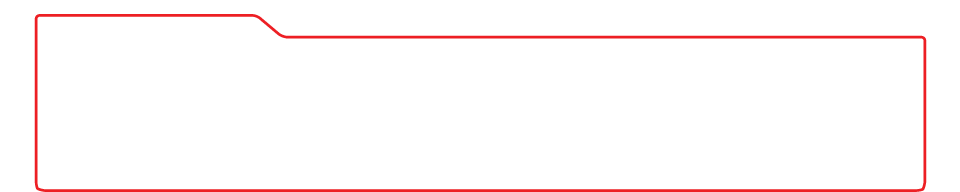
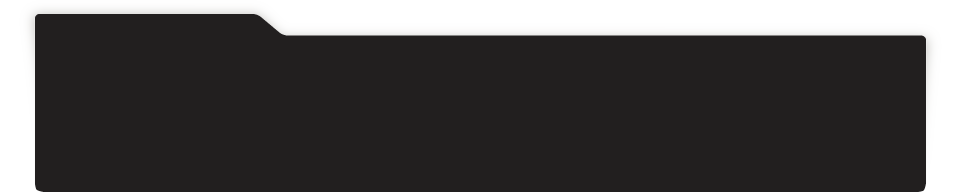
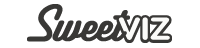
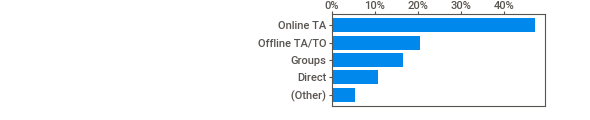
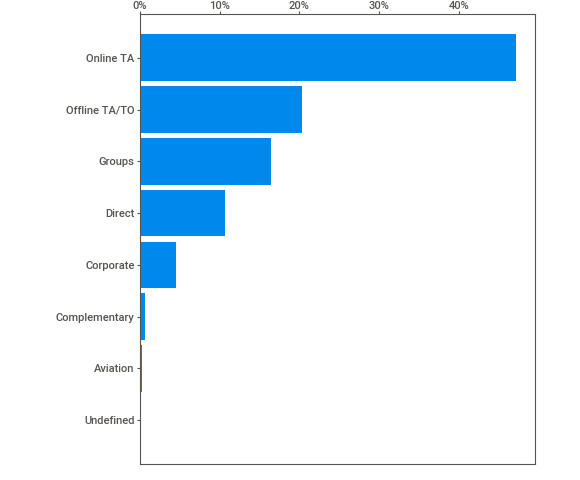
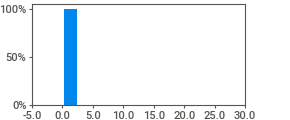
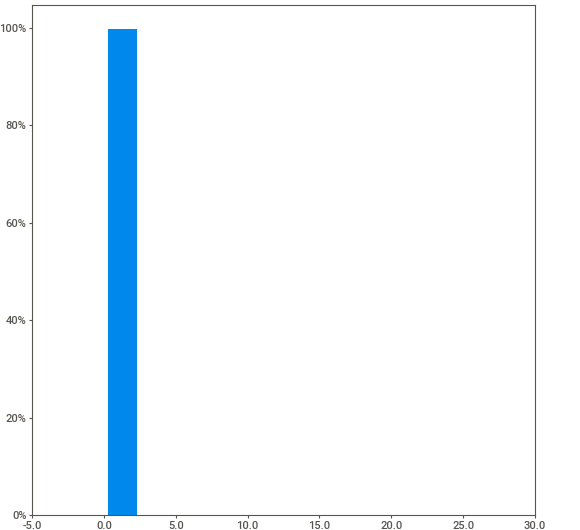
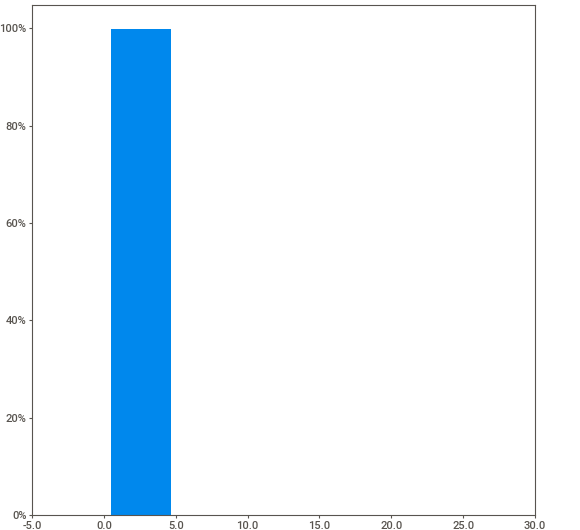
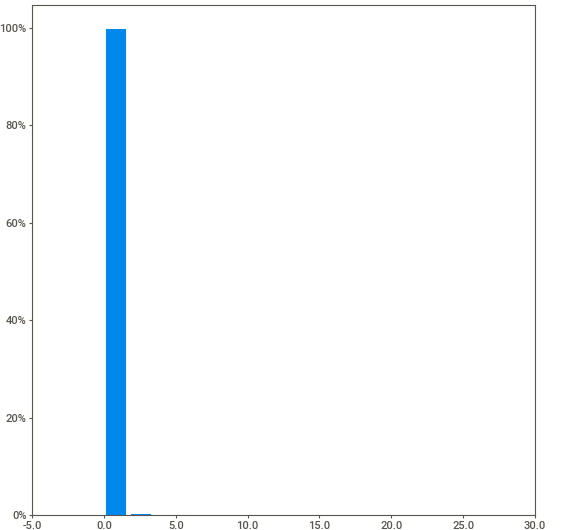
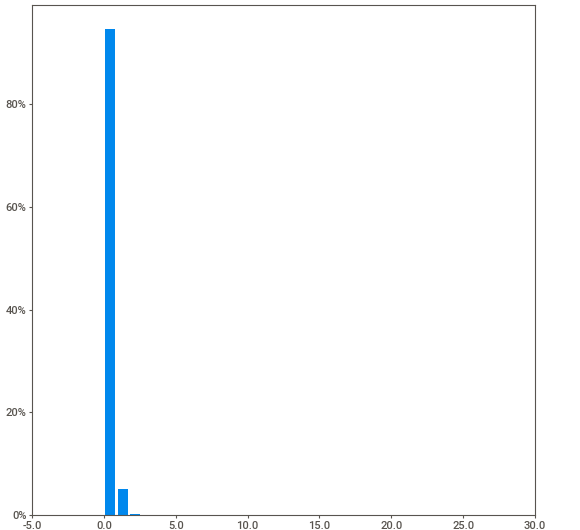
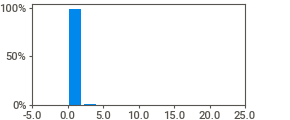
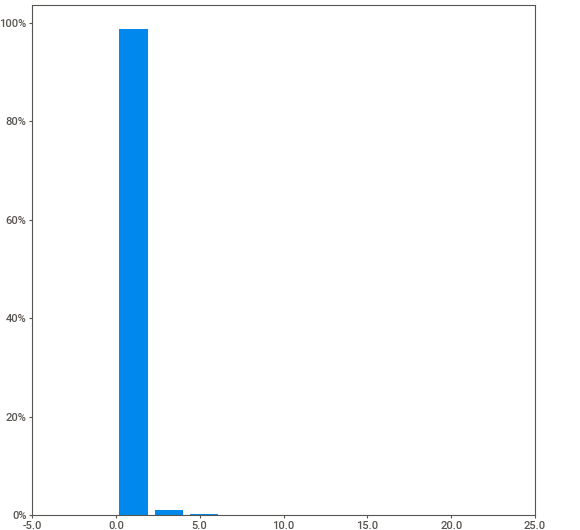
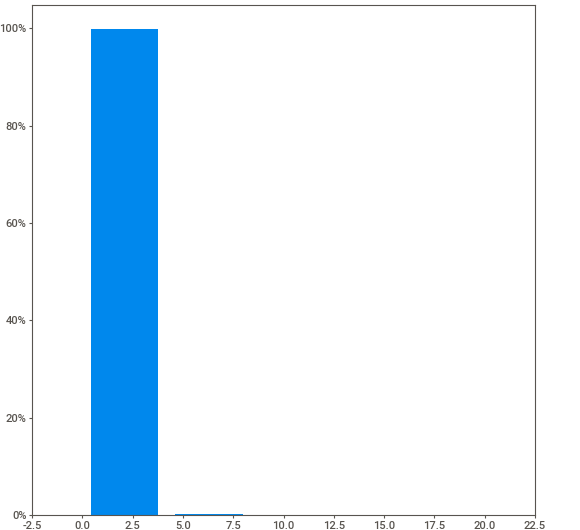
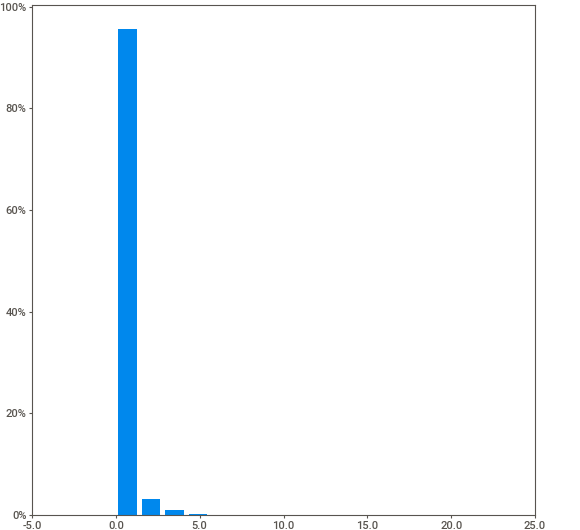
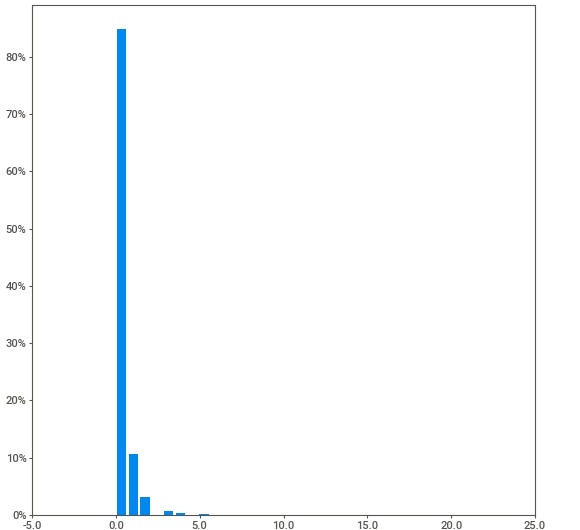
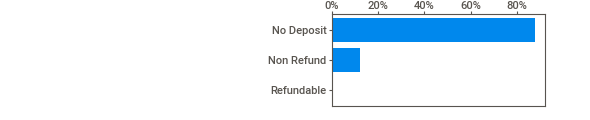
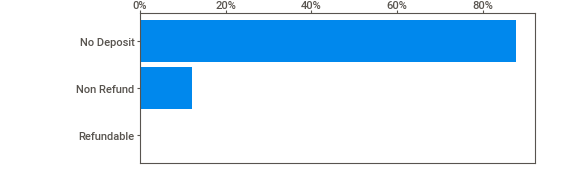
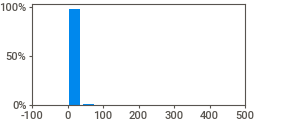
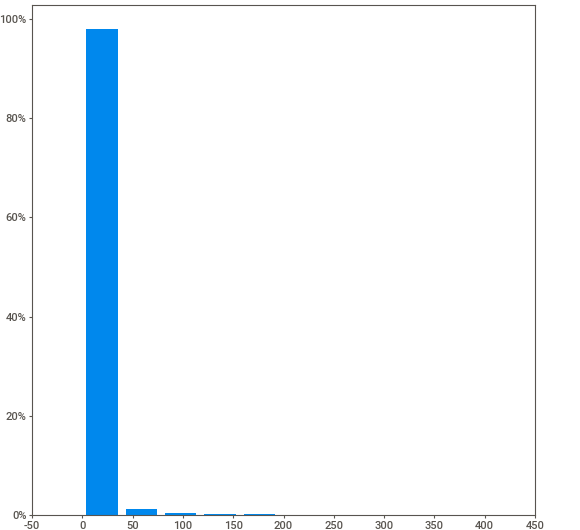
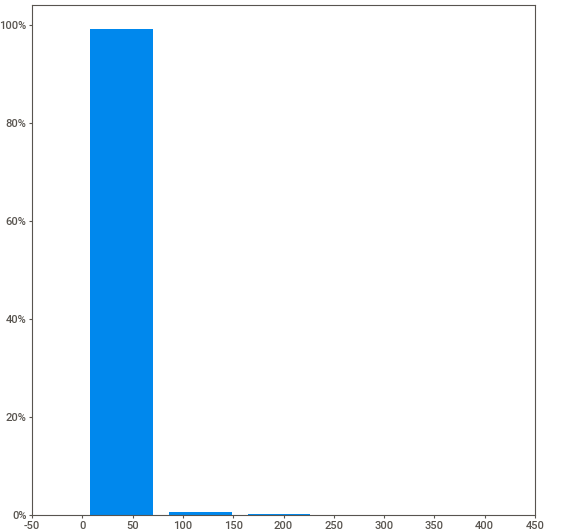
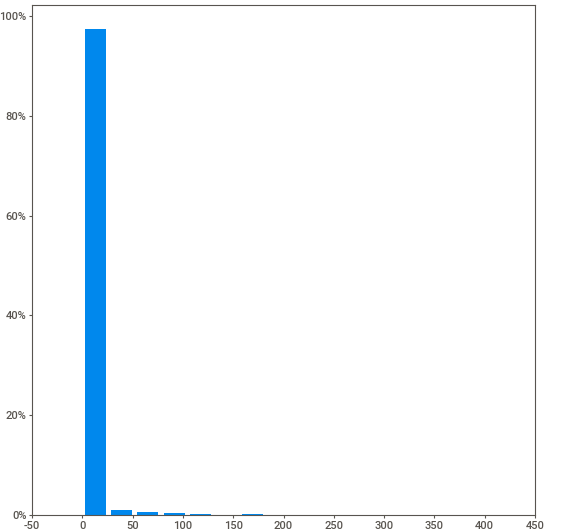
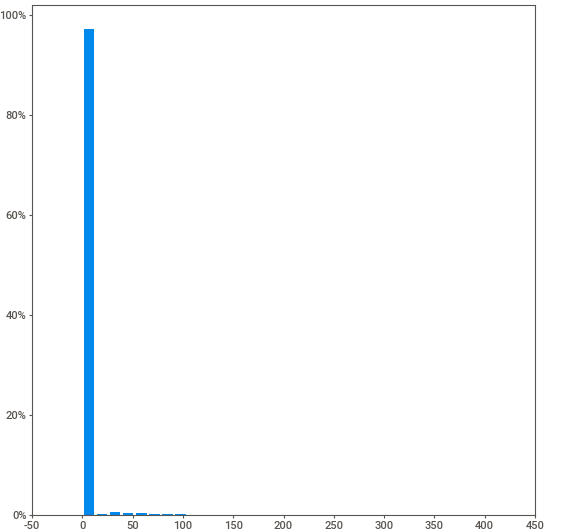
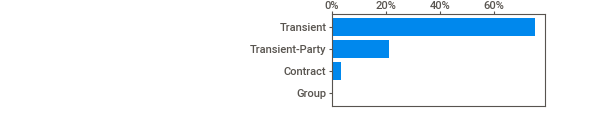
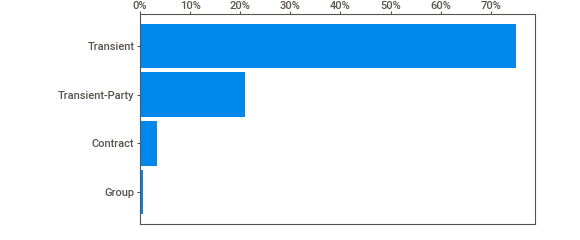
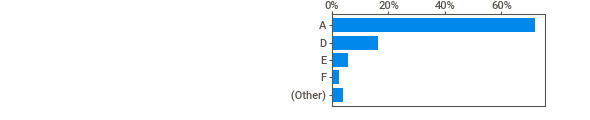
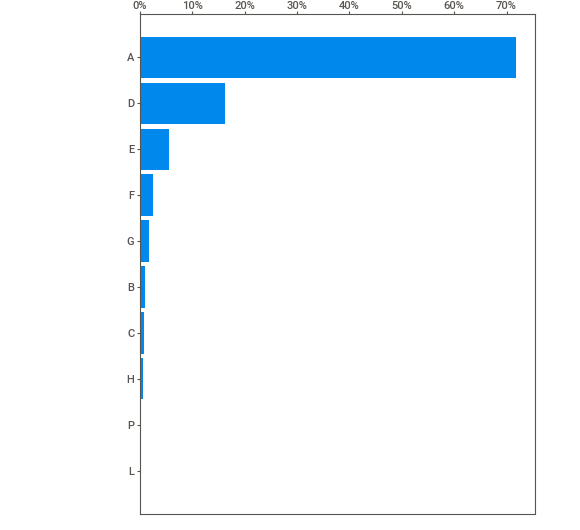
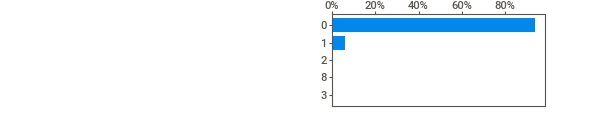
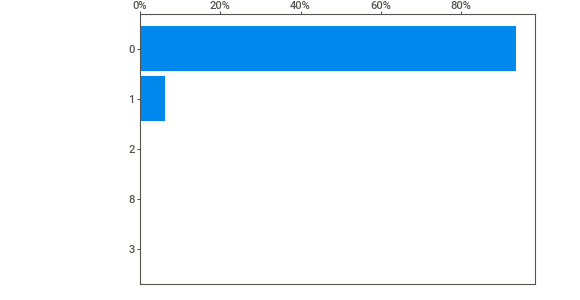
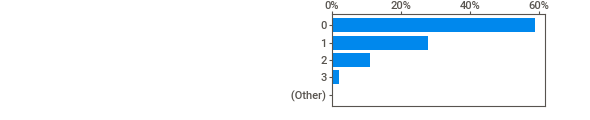
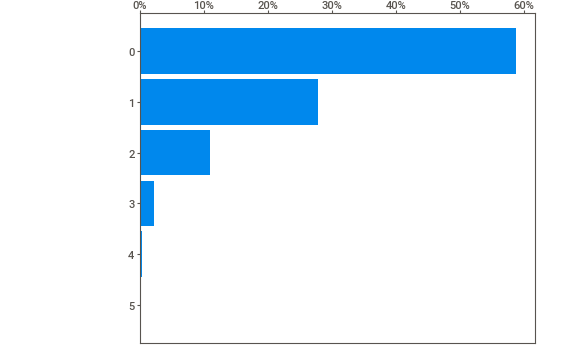
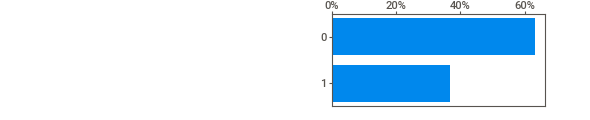
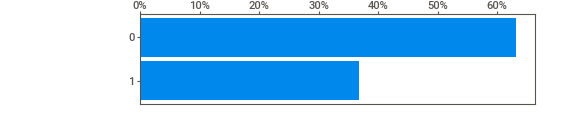
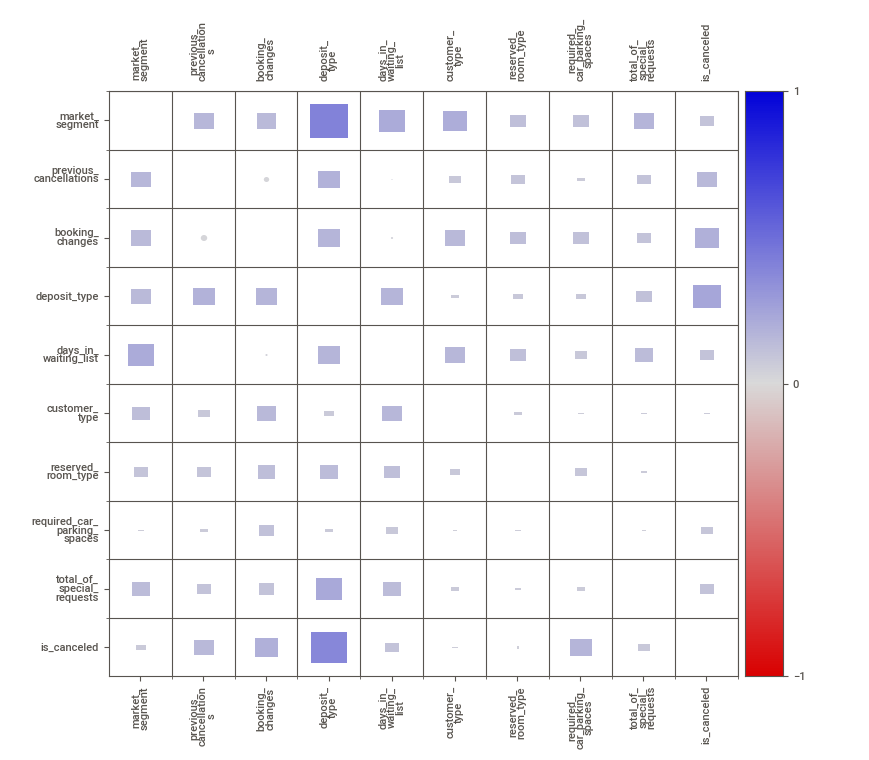
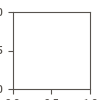

In [9]:
my_report.show_notebook()

Untuk melihat EDA pada D-Tale, dapat dilakukan dengan memilih opsi "Visualize" di kiri atas tabel lalu memilih opsi "Describe".

In [10]:
dtale.show(df)

Note :
- Dataset tidak seimbang
- Setiap baris merepresentasikan tamu hotel yang melakukan pemesanan
- Banyaknya duplikat dikarenakan tidak adanya `unique_id` setiap pemesanan, sehingga mungkin terjadi duplikat.

## 3. Data Cleaning

Seperti yang disebutkan sebelumnya, dikarenakan tidak adanya unique_id pada dataset tersebut yang menyebabkan duplikat, maka duplikat tidak akan dihapus.

### a. Menghapus Outliers

Berdasarkan EDA dari D-Tale, banyak kolom yang memiliki outliers. Akan tetapi, yang akan dihapus adalah outlier yang tidak memiliki *pattern*, nilainya cukup jauh dari nilai sebelumnya, atau yang *value* outliernya sangat sedikit.

Outlier yang akan kita hapus yaitu pada kolom `required_car_parking_spaces`, di mana row value 3 hanya terdiri dari 1 row dan row value 8 memiliki jarak yang cukup jauh dari sebelumnya dan hanya memiliki 2 rows.

In [11]:
df = df[df.required_car_parking_spaces != 3]
df = df[df.required_car_parking_spaces != 8]

### b. Menghapus Null Values

Berdasarkan EDA pada SweetViz, terdapat data yang hilang pada kolom country dengan jumlah data yang hilang sebesar 351 (<1%). Karena data yang hilang sangatlah kecil, maka kita akan menghapus baris yang memiliki missing value.

In [12]:
df.dropna(inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83219 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83219 non-null  object
 1   market_segment               83219 non-null  object
 2   previous_cancellations       83219 non-null  int64 
 3   booking_changes              83219 non-null  int64 
 4   deposit_type                 83219 non-null  object
 5   days_in_waiting_list         83219 non-null  int64 
 6   customer_type                83219 non-null  object
 7   reserved_room_type           83219 non-null  object
 8   required_car_parking_spaces  83219 non-null  int64 
 9   total_of_special_requests    83219 non-null  int64 
 10  is_canceled                  83219 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.6+ MB


Selanjutnya kita akan menghapus data "Undefined" pada kolom market segment, dikarenakan "Undefined" memiliki arti tidak diketahui atau Null.

In [14]:
df = df[df['market_segment'] != 'Undefined']

## 4. Feature Engineering

### a. Mengelompokkan Negara yang Memiliki Jumlah Row sedikit menjadi "Others"

Dikarenakan banyaknya jumlah kategori pada kolom `country`, maka akan dikelompokkan negara-negara yang memiliki jumlah rows di bawah 1000 menjadi Others. Hal ini ditujukan untuk menghindari terjadinya *Overfitting* nantinya.

In [15]:
top_negara = ['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'USA', 'NLD', 'CHE']

In [16]:
df['country'] = df['country'].apply(lambda x: x if x in top_negara else 'Others')

### b. Mengubah `days_in_waiting_list` yang bernilai 1 atau lebih

Dikarenakan 96.9% data memiliki value 0 pada kolom `days_in_waiting_list`, sedangkan 3.1% data memiliki values yang tersebar dari 1 hingga 391, maka dilakukan pengubahan value yang bernilai 1 atau lebih menjadi `1 or more day(s)`. Hal ini bertujuan untuk mengatasi ketidakseimbangan kelas yang ekstrim (96,9% nilai 0), dan juga untuk memfokuskan model pada kejadian daripada nilai spesifiknya.

In [17]:
# Map days_in_waiting_list
df['days_in_waiting_list'] = df['days_in_waiting_list'].apply(
    lambda x: "1 or more day(s)" if x >= 1 else 0
)
df['days_in_waiting_list'] = df['days_in_waiting_list'].astype(str)

## 5. Data Analysis

Pada data analisis ini akan dilihat persebaran data berdasarkan apakah tamu hotel melakukan pembatalan (1) atau tidak (0). <br>
Nantinya juga akan digunakan D-Tale untuk melihat berapa persentase value tiap kolom yang melakukan pembatalan atau tidak.

Penggunaan D-Tale pada kali ini:
1. Pilih option Visualize pada kiri atas tabel.
2. Pilih option Describe.
3. Pada tabel kiri, pilih kolom yang ingin dilihat.
4. Pilih option Frequency Table di samping table.
5. Pada Splits (Choose Col), pilih tabel `is_canceled`.

In [18]:
dtale.show(df)

Pertama akan dilihat kolom dengan nilai kategorikal:

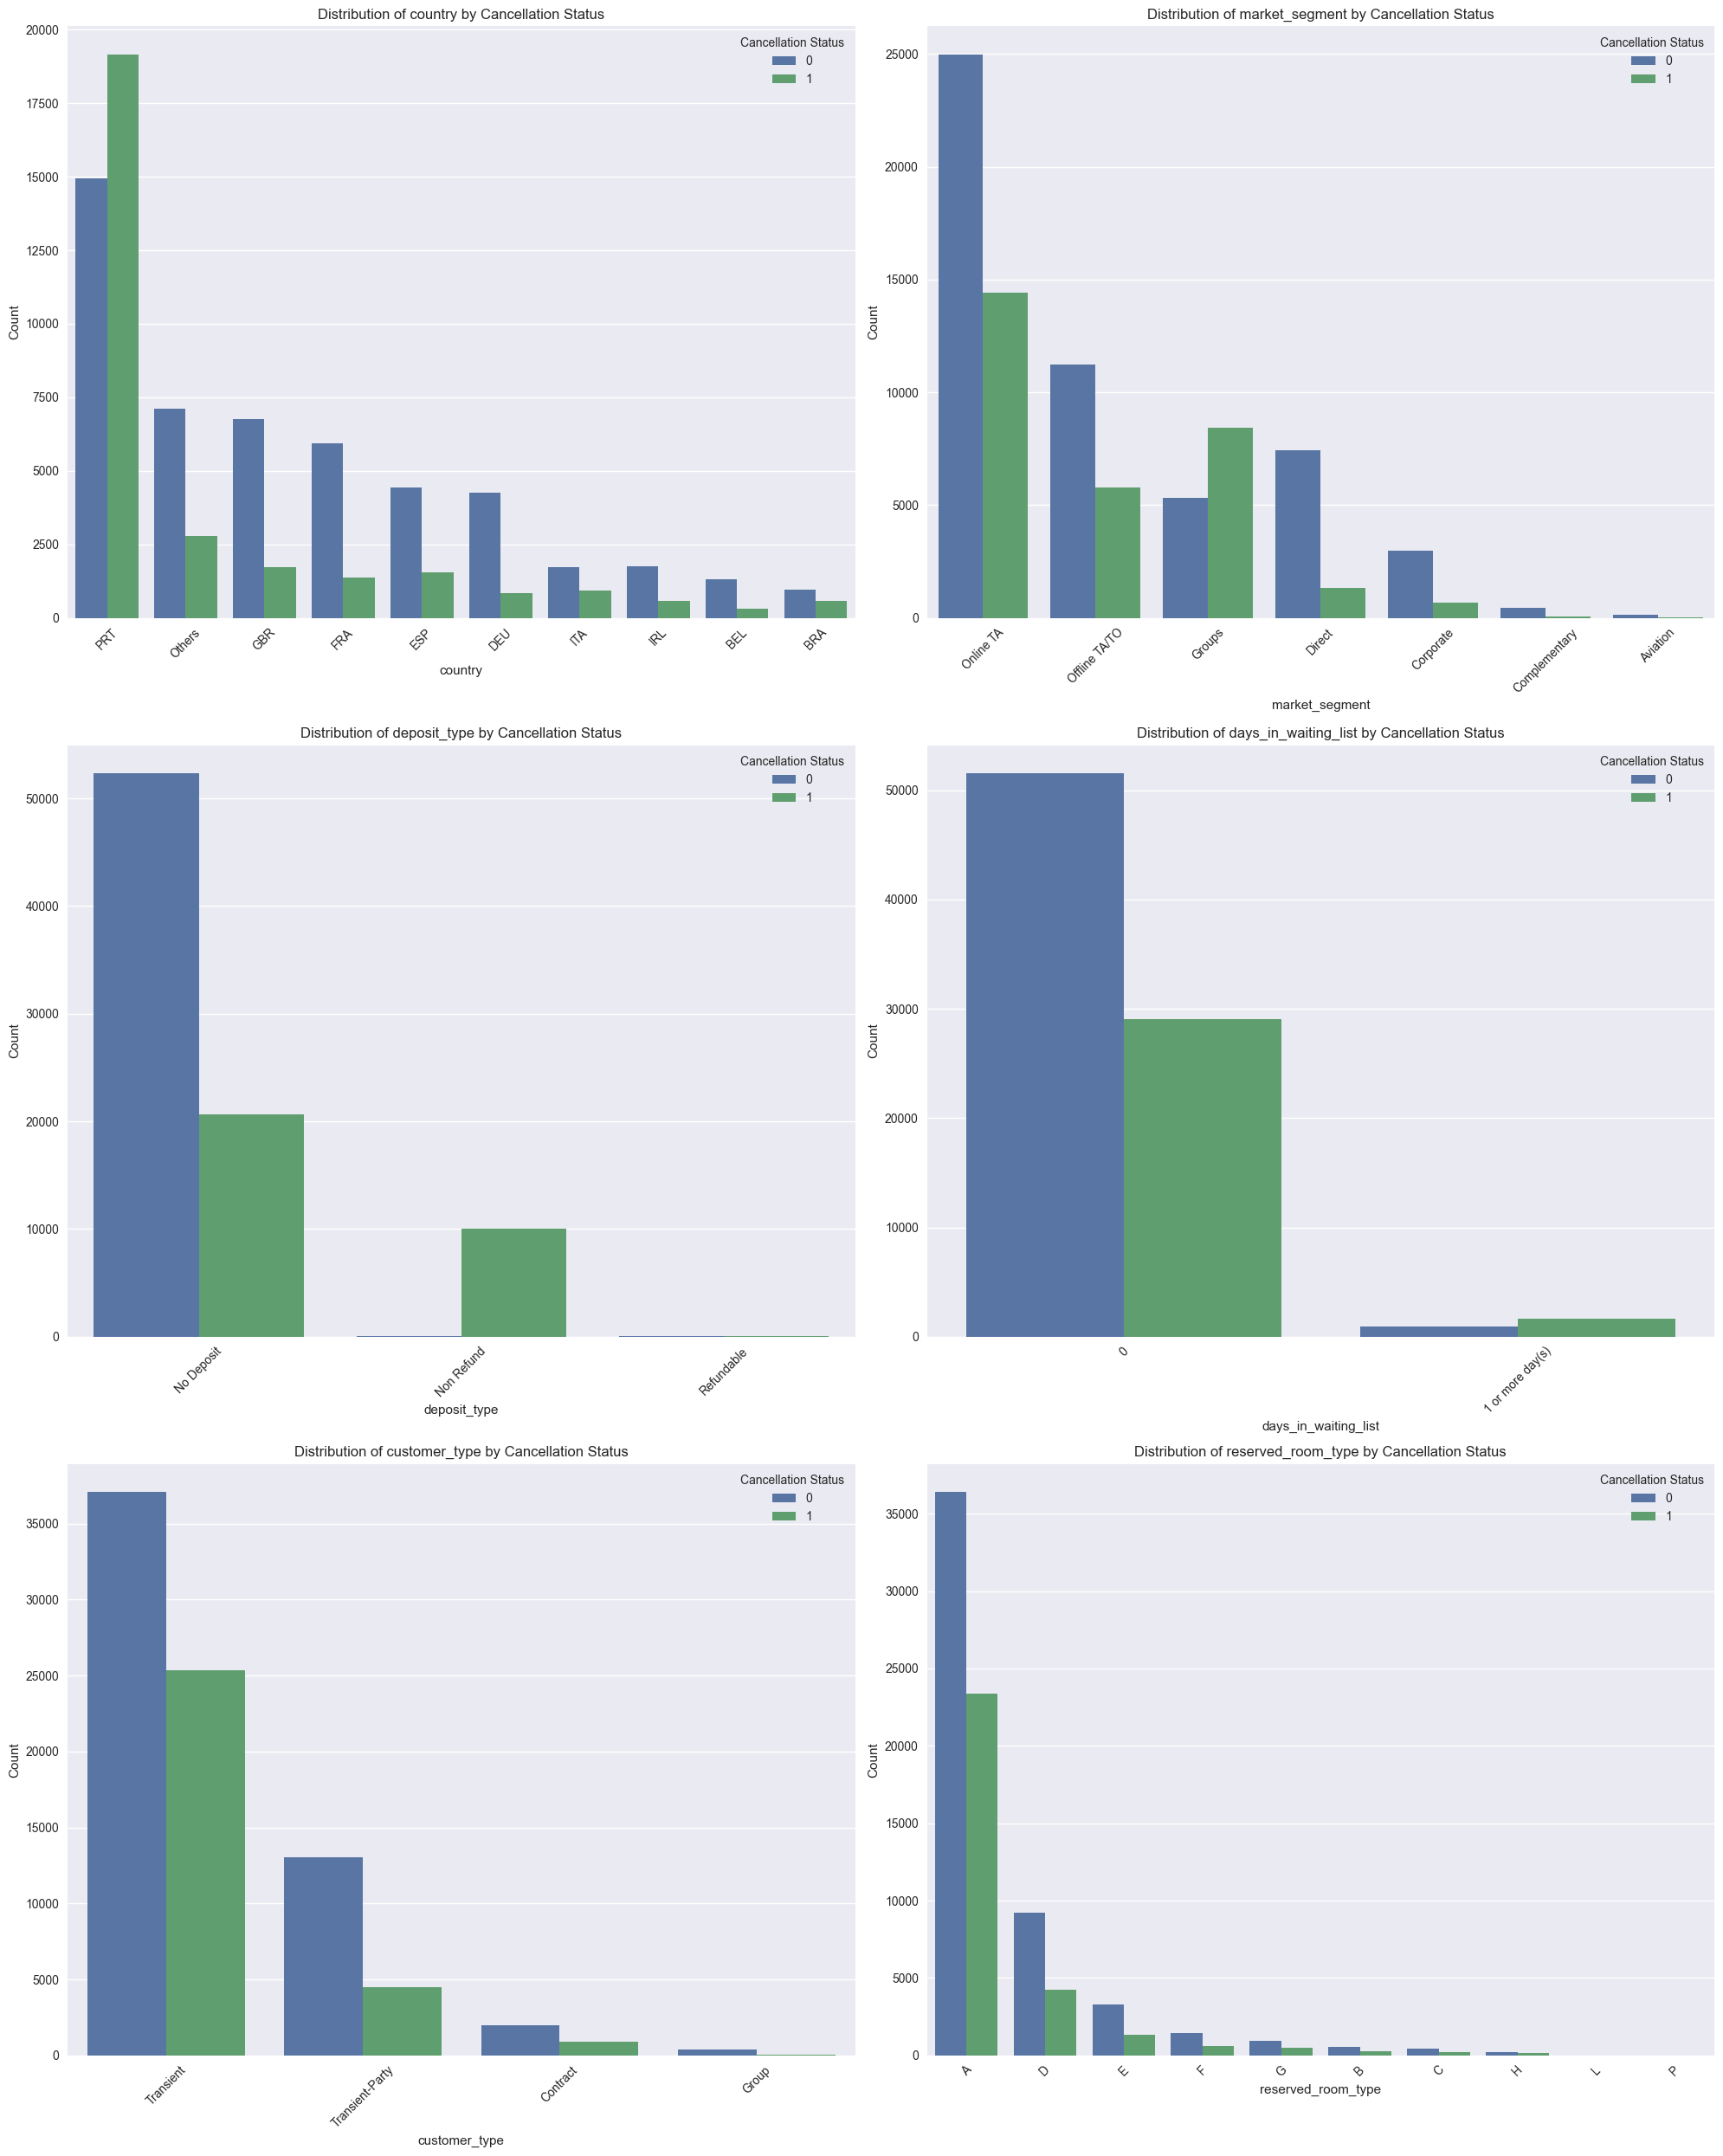

In [19]:
# Atur gaya untuk visualisasi yang lebih baik
plt.style.use('seaborn')

# Countplot untuk variabel kategorikal dengan is_cancelled sebagai hue
fig = plt.figure(figsize=(20, 25))
categorical_cols = ['country', 'market_segment', 'deposit_type', 'days_in_waiting_list', 
                   'customer_type', 'reserved_room_type']
numerical_cols = ['previous_cancellations', 'booking_changes', 'required_car_parking_spaces',
                 'total_of_special_requests']

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    # Dapatkan 10 kategori teratas untuk setiap variabel
    top_categories = df[col].value_counts().nlargest(10).index
    # Filter DataFrame untuk kategori teratas
    df_filtered = df[df[col].isin(top_categories)]
    
    sns.countplot(data=df_filtered, x=col, hue='is_canceled', order=top_categories)
    plt.title(f'Distribution of {col} by Cancellation Status')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Cancellation Status', labels=['0', '1'])

plt.tight_layout()
plt.show()

Berdasarkan Countplot di atas, maka dapat disimpulkan beberapa hal:
1. Tamu hotel yang berasal dari Portugal (`PRT`) lebih cenderung melakukan pembatalan dibandingkan tamu dari negara lain.
2. Tamu hotel dari segmen pasar `Groups` lebih cenderung melakukan pembatalan dibandingkan tamu dari segmen pasar yang lain.
3. Hampir semua (99.38%) tamu hotel dengan tipe deposit `Non Refund` melakukan pembatalan.
4. Tamu hotel yang memiliki jumlah hari pemesanan berada dalam daftar tunggu `1 or more day(s)` cenderung melakukan pembatalan dibandingkan tamu dari segmen pasar yang lain.
5. Tamu hotel dengan tipe pelanggan `Transient` memiliki persentase terbesar untuk melakukan pembatalan (40.59%).
6. Tipe kamar yang direservasi cenderung tidak memengaruhi pembatalan dari tamu hotel.

Selanjutnya akan dilihat grafik dari kolom yang memiliki nilai numerical:

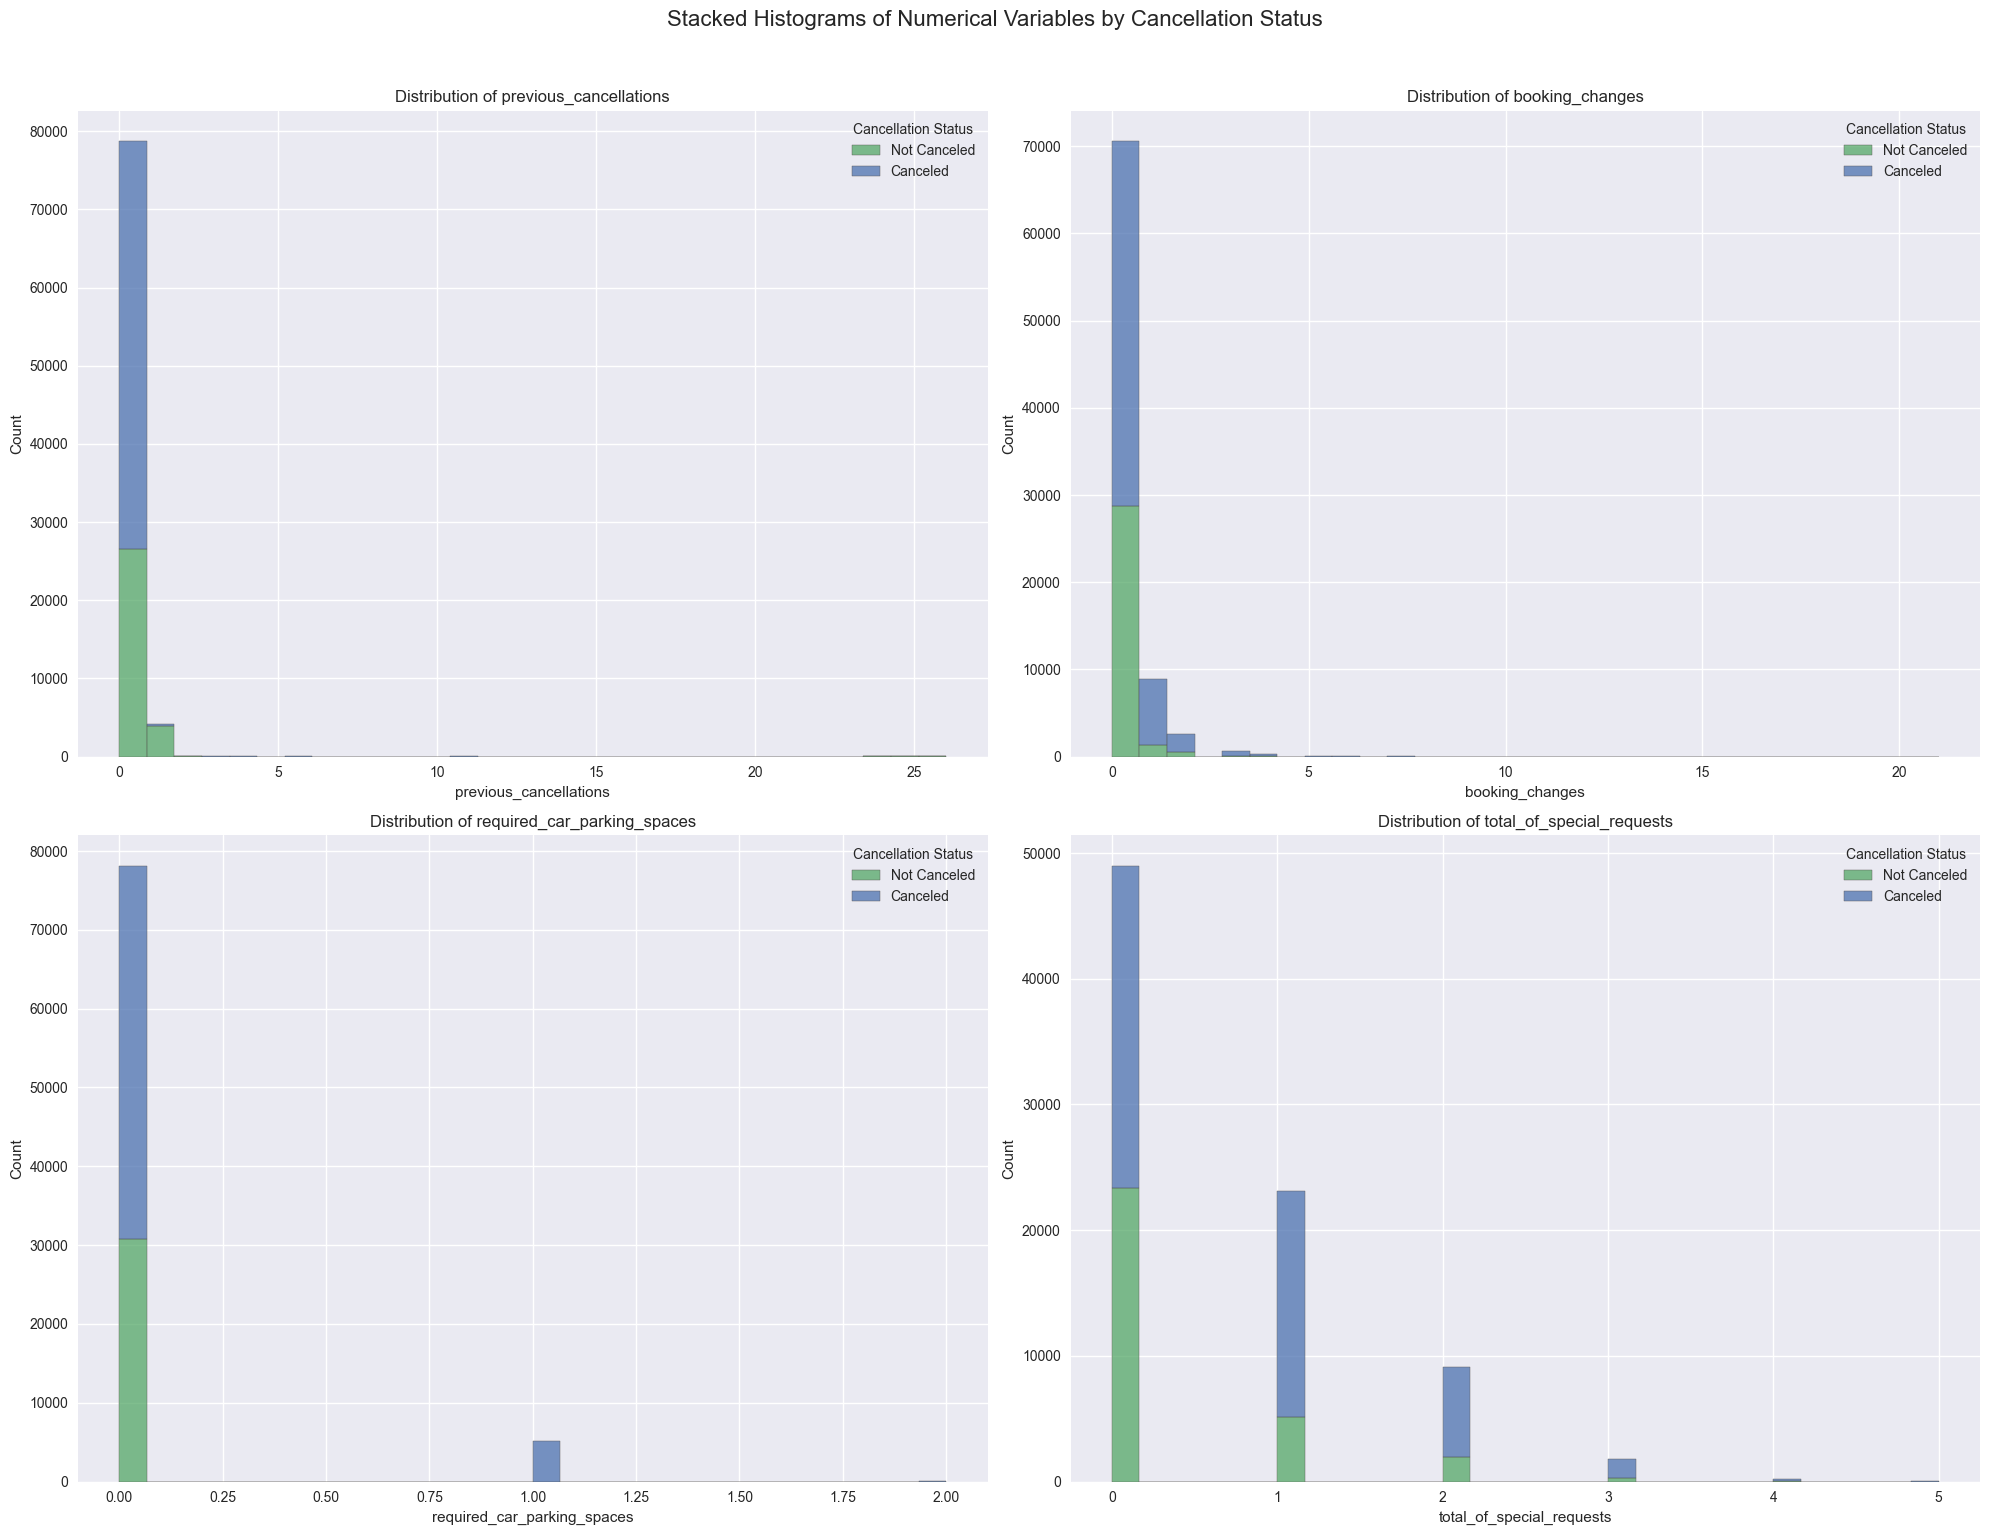

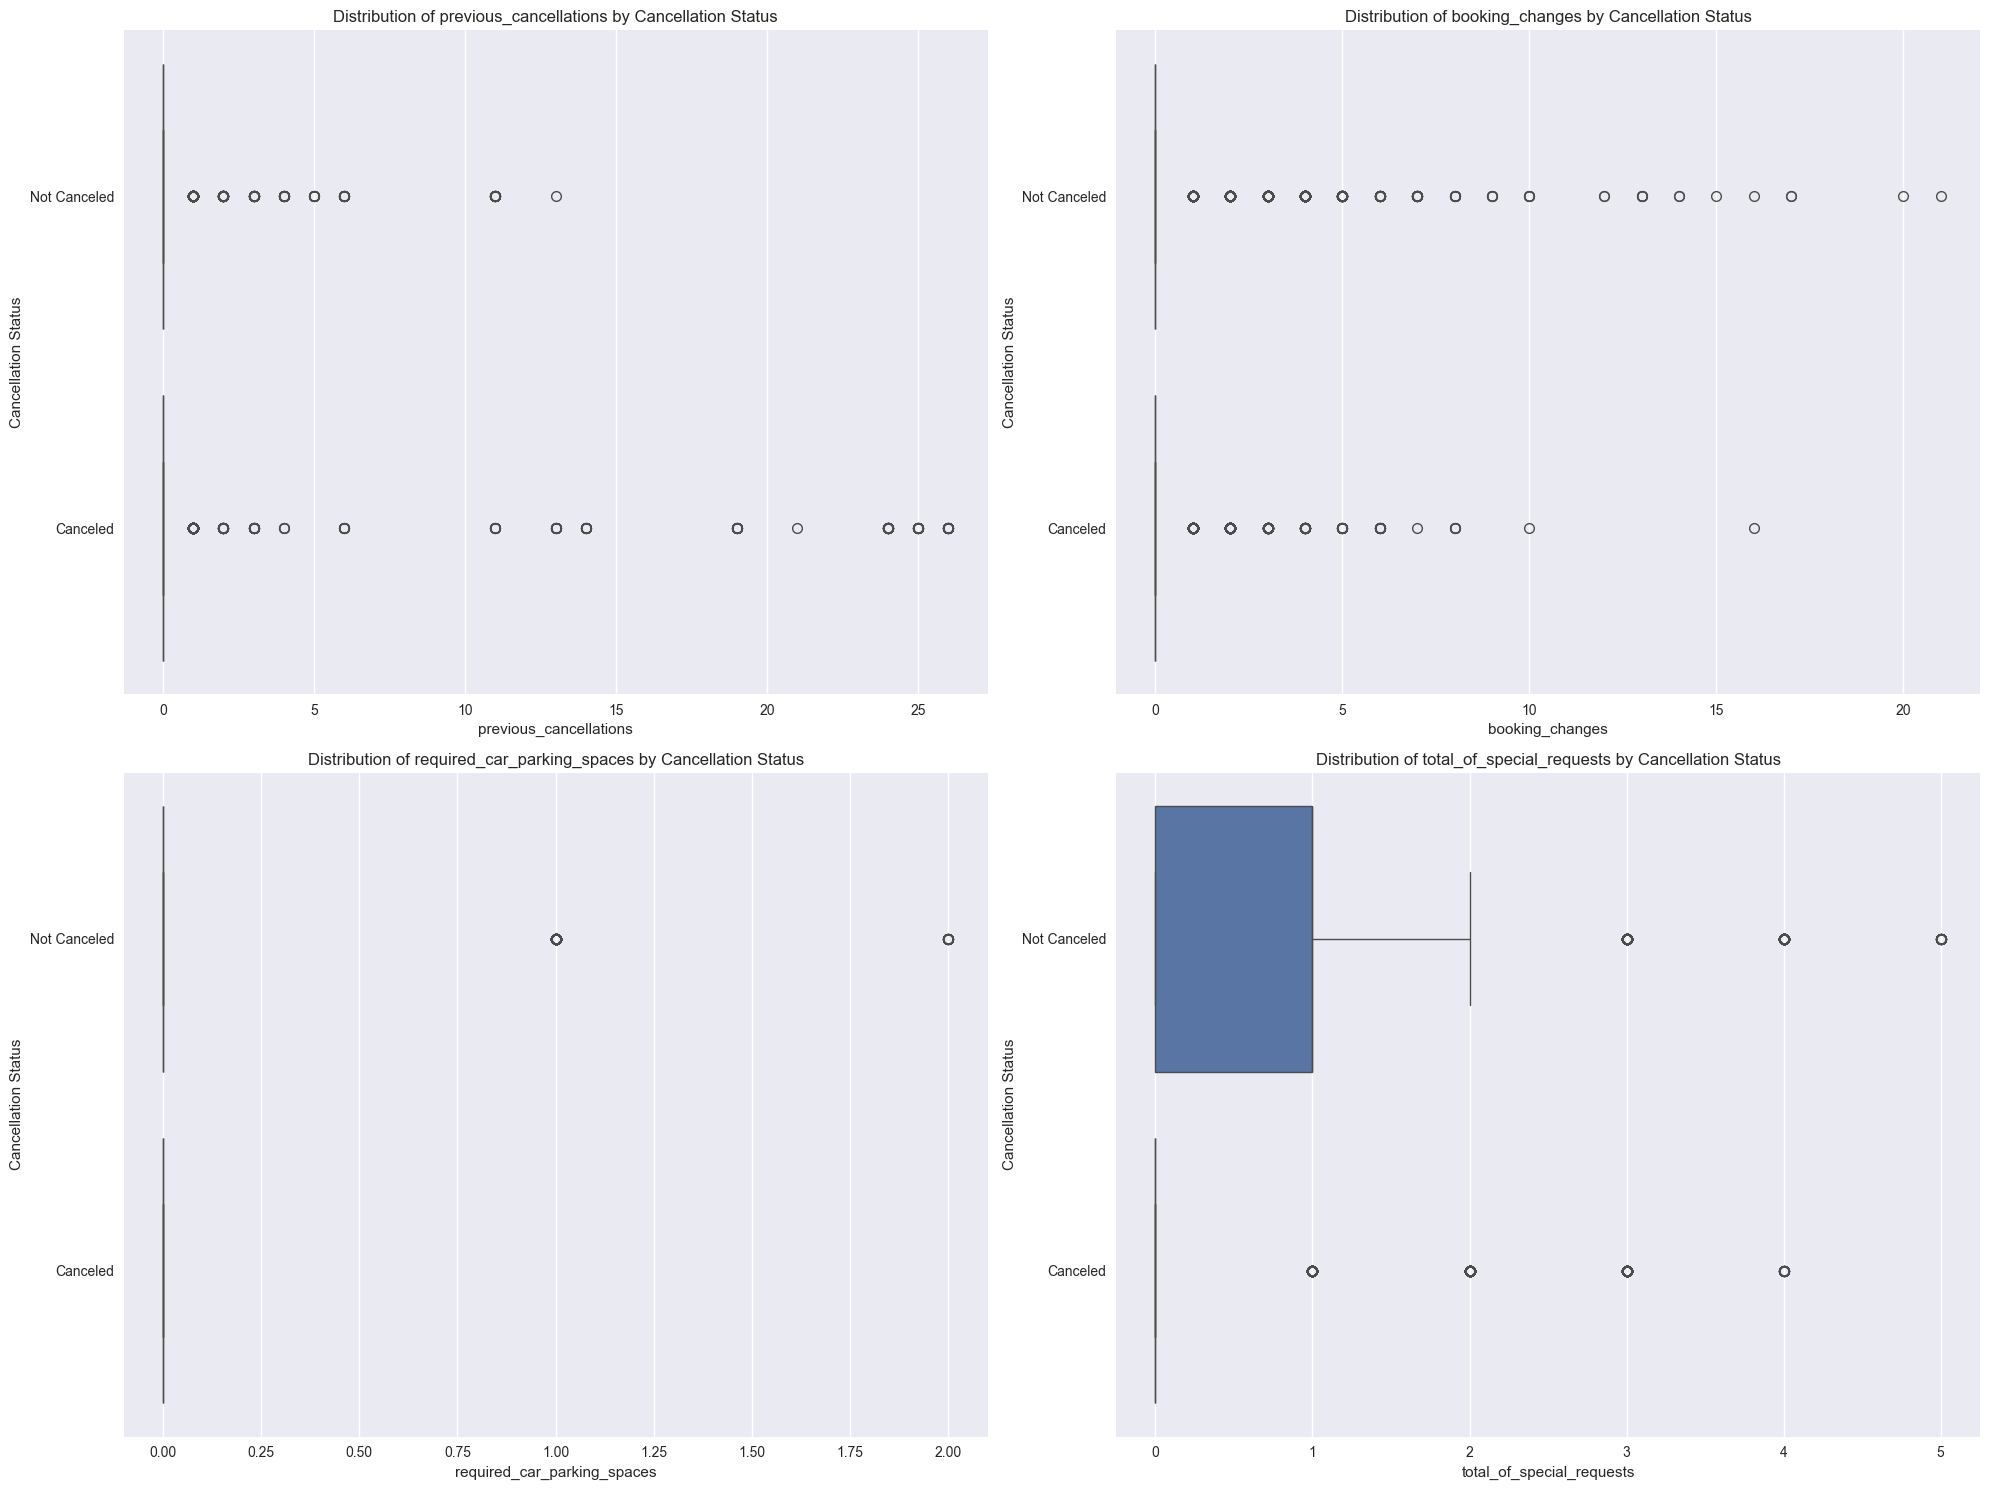

In [20]:
# Stacked histograms
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Stacked Histograms of Numerical Variables by Cancellation Status', fontsize=16, y=1.02)

for i, col in enumerate(numerical_cols):
    row = i // 2
    col_idx = i % 2
    
    # Stacked histogram
    sns.histplot(data=df, 
                x=col, 
                hue='is_canceled',
                multiple="stack",
                bins=30,
                ax=axes[row, col_idx])
    
    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Count')
    axes[row, col_idx].legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])

plt.tight_layout()
plt.show()

# Horizontal boxplots
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    
    # Membuat plot kotak horizontal
    sns.boxplot(data=df,
                x=col,
                y='is_canceled',
                hue='is_canceled',
                orient='h')
    
    plt.title(f'Distribution of {col} by Cancellation Status')
    plt.ylabel('Cancellation Status')
    plt.xlabel(col)
    # Menyesuaikan label y-axis
    plt.yticks([0, 1], ['Not Canceled', 'Canceled'])
    # Menghapus legenda yang berlebihan
    plt.legend([])

plt.tight_layout()
plt.show()

Berdasarkan grafik di atas dan tabel pada D-Tale, maka dapat disimpulkan beberapa hal:
1. Tamu hotel yang sebelumnya pernah melakukan pembatalan sebanyak `1` kali atau `13 lebih` kali cenderung untuk melakukan pembatalan dibandingkan yang lainnya.
2. Tamu hotel yang pernah melakukan penggantian booking ataupun yang belum pernah cenderung untuk tidak melakukan pembatalan.
3. Tamu hotel yang meminta ruang tempat memarkirkan mobil maupun yang tidak cenderung untuk tidak melakukan pembatalan.
4. Tamu hotel yang meminta permintaan khusus maupun yang tidak cenderung untuk tidak melakukan pembatalan.

## Define X and y

Karena target adalah tamu hotel yang melakukan pembatalan atau tidak, maka target (`y`) adalah kolom `is_canceled`. <br>
Semua kolom selain itu akan dimasukkan ke dalam Features (`X`).

In [21]:
# Define X y
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

## Splitting

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

## Preprocessing

Pada tahap ini akan dilakukan Feature Encoding untuk Feature Categorical dan Scaling untuk Feature Numerical.
1. Berdasarkan tabel pada D-Tale mengenai `days_in_waiting_list`, nilai `0` memiliki nilai 0 pada tabel `is_canceled` lebih banyak (63.95%) dan nilai `1 or more day(s)` memiliki nilai 1 pada tabel `is_canceled` lebih banyak (64.28%). Berdasarkan kesimpulan ini, maka akan dilakukan **Ordinal Encoding** dengan `0` memiliki nilai 1 dan `1 or more day(s)` memiliki nilai `2`.
2. Feature `country`, `market_segment`, `deposit_type`, `customer_type`,`reserved_room_type` akan dilakukan **Binary Encoding**, dikarenakan Feature-feature ini tidak memiliki urutan. Penggunaan Binary Encoding dibandingkan One-hot Encoding dikarenakan pengontrolan dimensionality (One-hot Encoding menghasilkan 3 - 13 kolom, sedangkan Binary Encoding menghasilkan 4 kolom), dan juga untuk efisiensi memori.
3. Feature `previous_cancellations`, `booking_changes`,`required_car_parking_spaces`,`total_of_special_requests` akan dilakukan **Robust Scaling**, dikarenakan berdasarkan grafik-grafik sebelumnya terdapat outliers yang banyak dan distribusi fitur sangat skew kanan. Metode ini memastikan agar Scaling tidak terdistorsi oleh nilai ekstrim, sehingga menghasilkan kinerja model yang lebih stabil dan kuat.

In [23]:
ordinal_encoder_maps = [
    {
    'col': 'days_in_waiting_list',
    'mapping': {
        '0': 1,
        '1 or more day(s)':2,
    }
}]

In [24]:
transformer = ColumnTransformer([
    ('ordinal_encoder', OrdinalEncoder(cols=['days_in_waiting_list'], mapping=ordinal_encoder_maps), ['days_in_waiting_list']),
    ('binary_encoder', BinaryEncoder(), ['country', 'market_segment', 'deposit_type', 'customer_type','reserved_room_type']),
    ('robust_scaling', RobustScaler(), ['previous_cancellations', 'booking_changes','required_car_parking_spaces','total_of_special_requests'])
], remainder='passthrough')

In [25]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal_encoder',
                                 OrdinalEncoder(cols=['days_in_waiting_list'],
                                                mapping=[{'col': 'days_in_waiting_list',
                                                          'data_type': dtype('O'),
                                                          'mapping': 0                   1
1 or more day(s)    2
dtype: int64}]),
                                 ['days_in_waiting_list']),
                                ('binary_encoder', BinaryEncoder(),
                                 ['country', 'market_segment', 'deposit_type',
                                  'customer_type', 'reserved_room_type']),
                                ('robust_scaling', RobustScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests'])])

## Benchmark Model

Model klasifikasi yang akan dilakukan uji coba adalah sebagai berikut:
1. **Logistic Regression**: Model linier yang memprediksi probabilitas untuk masalah klasifikasi biner menggunakan fungsi logistik (sigmoid).  
2. **KNeighborsClassifier**: Model non-parametrik yang mengklasifikasikan titik data berdasarkan kelas mayoritas dari k-nearest neighbors dalam ruang fitur.  
3. **Decision Tree Classifier**: Tree-based model yang membuat keputusan dengan membagi data pada ambang batas fitur untuk memaksimalkan pemisahan kelas.  
4. **XGBClassifier**: Model gradient boosting yang sangat efisien yang membangun ensemble dari decision tree dengan mengoptimalkan kinerja klasifikasi secara berulang.  
5. **RandomForestClassifier**: Model ensemble yang menggabungkan beberapa decision tree, yang dilatih pada subset data dan fitur secara acak, untuk meningkatkan akurasi dan mengurangi overfitting.

In [26]:
# Tentukan model
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
xgb = XGBClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)

In [27]:
# Pilihan model
models = [logreg, knn, tree, xgb, rf]

cv_mean = []
cv_std = []
cv_all = []


# Mencari model terbaik berdasarkan mean terbesar dan std terkecil
for i in models:
    
    skfold = StratifiedKFold(n_splits = 5, shuffle=True,random_state=0)

    model_pipe = Pipeline([
        ('resampler', None),
        ('prep', transformer), 
        ('model', i)])
    
    model_cv = cross_val_score(
        model_pipe, 
        X_train, 
        y_train, 
        cv = skfold, 
        scoring = 'recall',
        error_score='raise'
        )

    cv_mean.append(model_cv.mean())
    cv_std.append(model_cv.std())
    cv_all.append(model_cv.round(4))

In [28]:
df_cv = pd.DataFrame({
    'algo': models,
    'mean': cv_mean,
    'std': cv_std,
    'all': cv_all
})

df_cv

,algo,mean,std,all
0,LogisticRegression(random_state=0),0.557250,0.010539,"[0.5749, 0.5568, 0.543, 0.5599, 0.5516]"
1,KNeighborsClassifier(),0.658694,0.020582,"[0.6838, 0.6565, 0.6652, 0.6665, 0.6215]"
2,DecisionTreeClassifier(random_state=0),0.682367,0.014999,"[0.6935, 0.6984, 0.6846, 0.6553, 0.6801]"
3,"XGBClassifier(base_score=None, booster=None, c...",0.684971,0.006541,"[0.6827, 0.6899, 0.6746, 0.6937, 0.684]"
4,RandomForestClassifier(random_state=0),0.689445,0.020189,"[0.7208, 0.7016, 0.6772, 0.6622, 0.6854]"


Berdasarkan hasil, maka akan dipilih model yaitu XGBoost. Alasan pemilihan yaitu:
1. Merupakan model dengan nilai mean tinggi dan nilai std paling rendah.
2. XGBoost merupakan model berbasis tree, dan memproses Feature numerik secara langsung dengan membuat pemisahan berdasarkan nilai Feature. <br>
Karena sebelumnya juga menggunakan BinaryEncode dibanding OneHotEncoder, di mana BinaryEncoder menghasilkan representasi numerik ringkas yang efisien untuk algoritme tersebut. Sedangkan OneHotEncoder, sebagai perbandingan, memperkenalkan Feature-feature berdimensi tinggi, sehingga kurang efisien untuk model berbasis tree.

### Cara XGBoost Bekerja

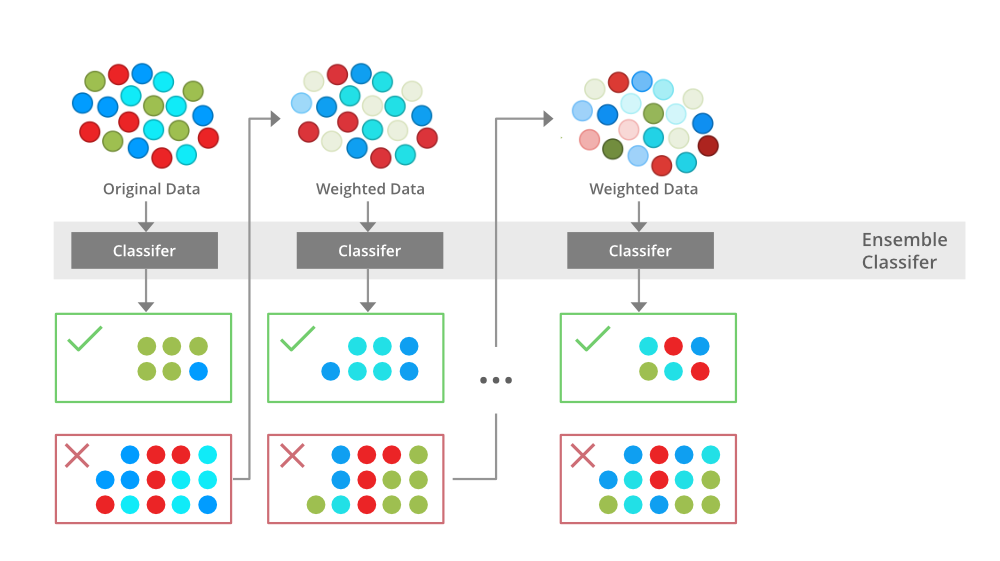<br>
Source: [www.geeksforgeeks.org](https://www.geeksforgeeks.org/xgboost/)

Boosting adalah metode pembelajaran ensemble yang menggabungkan beberapa pembelajar  lemah (model yang berkinerja sedikit lebih baik daripada tebakan acak) untuk membuat model prediktif yang kuat. Ide dasar dari boosting adalah melatih pelajar yang lebih lemah, satu demi satu, masing-masing mencoba memperbaiki kesalahan pelajar sebelumnya. Proses berulang ini berfokus pada contoh-contoh sulit dan secara bertahap meningkatkan kinerja keseluruhan  ansambel.

Trees pada XGBoost belajar dari kesalahan satu sama lain. Selama pelatihan, setiap tree baru disajikan dengan kesalahan dari tree sebelumnya. Dengan berfokus pada kasus-kasus sulit ini, tree baru tersebut mampu menyempurnakan batasan keputusannya dan meningkatkan kinerja keseluruhan ansambel. Proses pembelajaran  berulang ini memungkinkan XGBoost untuk terus meningkatkan kekuatan prediktifnya.

## Hyperparameter Tuning

---
Reference:
1. [XGBoost Hyperparameter Optimization with Hyperopt](https://xgboosting.com/xgboost-hyperparameter-optimization-with-hyperopt/)
2. [Tune XGBoost "max_depth" Parameter](https://xgboosting.com/tune-xgboost-max_depth-parameter/)
3. [Tune XGBoost "learning_rate" Parameter](https://xgboosting.com/tune-xgboost-learning_rate-parameter/)
4. [Tune XGBoost "n_estimators" Parameter](https://xgboosting.com/tune-xgboost-n_estimators-parameter/)
5. [Tune XGBoost "min_child_weight" Parameter](https://xgboosting.com/tune-xgboost-min_child_weight-parameter/)
6. [XGBoost Tune "scale_pos_weight" Parameter](https://xgboosting.com/xgboost-tune-scale_pos_weight-parameter/)
7. [Tune XGBoost "max_delta_step" Parameter](https://xgboosting.com/tune-xgboost-max_delta_step-parameter/)
---

Module yang digunakan untuk Hyperparameter Tuning adalah Hyperopt. Alasan penggunaan Hyperopt dibandingkan dengan GridSearch atau RandomSearch adalah karena Hyperopt menggunakan optimasi Bayesian cerdas (Tree of Parzen Estimators) untuk belajar dari uji coba sebelumnya dan fokus pada wilayah yang menjanjikan, sehingga lebih efisien daripada brute-force GridSearch atau pengambilan sampel acak RandomSearch.

Parameter yang akan dilakukan tuning adalah:
1. `max_depth`: Parameter max_depth di XGBoost mengontrol kedalaman maksimum dari decision tree yang digunakan dalam model.
2. `learning_rate`: Parameter learning_rate dalam XGBoost mengontrol ukuran langkah pada setiap iterasi boosting.
3. `n_estimators`: Parameter n_estimator di XGBoost mengontrol jumlah putaran boosting atau tree yang dibangun oleh algoritma.
4. `min_child_weight`: Parameter min_child_weight di XGBoost mengontrol jumlah minimum bobot instance (hessian) yang dibutuhkan dalam child node.
5. `scale_pos_weight`: Ketika bekerja dengan set data yang tidak seimbang dalam klasifikasi biner, di mana satu kelas secara signifikan melebihi kelas yang lain, sangat penting untuk menyesuaikan parameter scale_pos_weight di XGBoost untuk mencapai kinerja yang optimal.
6. `max_delta_step`: Parameter max_delta_step di XGBoost membatasi perubahan maksimum yang diperbolehkan dalam prediksi antara iterasi.

`scale_pos_weight` digunakan untuk mengatasi imbalance data.`scale_pos_weight` digunakan pada XGBoost karena secara langsung mengatasi class imbalance selama model training tanpa mengubah dataset atau berisiko overfitting, tidak seperti metode oversampling atau undersampling seperti ROS, RUS, atau SMOTE.

Default dari Hyperparameter yang digunakan Hyperopt untuk XGBoost adalah sebagai berikut:
1. `max_depth`: uniform 1 hingga 11
2. `learning_rate`: log uniform 0.0001 hingga 0.5
3. `n_estimators`: 100 to 6000 dalam satuan 200
4. `min_child_weight`: log uniform dari 1 hingga 100

In [29]:
space = {
        'max_depth' : hp.choice('max_depth',
                                       range(5, 15, 1)),
        'learning_rate' : hp.loguniform('learning_rate',
                                             -5,-1),
        'n_estimators' : scope.int(hp.quniform("n_estimators", 100, 150, 25)),
        'min_child_weight': scope.int(hp.quniform("min_child_weight", 1, 20, 1)),
        'scale_pos_weight': hp.uniform("scale_pos_weight", 0.9, 2),
        'max_delta_step': hp.choice("max_delta_step", [1,3,5,7,10]),
    }

In [30]:
# Mendefinisikan fungsi objektif yang kerugiannya harus diminimalkan
def objective(args):
    
    # Menginisialisasi pipeline model
    model_pipe = Pipeline([
        ('prep', transformer),
        ('model', XGBClassifier(random_state=0, **args))])
    
    
    # Cross Validation Score.
    try:
        skfold = StratifiedKFold(n_splits = 5, shuffle=True,random_state=0)
        model_cv = cross_val_score(
            model_pipe, 
            X_train, 
            y_train, 
            cv = skfold, 
            scoring = 'recall',
            )
                
        # Karena harus meminimalkan skor, kita mengembalikan 1- skor.
        return {'loss': 1 - model_cv.mean(), 'status': STATUS_OK}
    
    except Exception as e:
        return {'loss': np.inf, 'status': STATUS_FAIL}

In [31]:
np.seterr(under='ignore') # mengabaikan underflow error

# Hyperopts Trials() merekam semua model dan menjalankan artefak.
trials = Trials()

# Fmin akan memanggil fungsi objektif dengan set parameter selektif. 
# Pilihan algoritma akan mempersempit ruang pencarian.

best_classifier = fmin(objective, space, algo=tpe.suggest,
                       max_evals=50, trials=trials, rstate=np.random.default_rng(42))

# Ruang_terbaik dari model terbaik
best_params = space_eval(space, best_classifier)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

2025-01-14 13:48:54,197 - INFO     - build_posterior_wrapper took 0.000999 seconds
2025-01-14 13:48:54,197 - INFO     - TPE using 0 trials


  2%|▏         | 1/50 [00:01<01:07,  1.38s/trial, best loss: 0.2080130160667073]

2025-01-14 13:48:55,573 - INFO     - build_posterior_wrapper took 0.001000 seconds
2025-01-14 13:48:55,573 - INFO     - TPE using 1/1 trials with best loss 0.208013


  4%|▍         | 2/50 [00:02<01:12,  1.51s/trial, best loss: 0.2080130160667073]

2025-01-14 13:48:57,184 - INFO     - build_posterior_wrapper took 0.002002 seconds
2025-01-14 13:48:57,185 - INFO     - TPE using 2/2 trials with best loss 0.208013


  6%|▌         | 3/50 [00:04<01:07,  1.45s/trial, best loss: 0.2080130160667073]

2025-01-14 13:48:58,548 - INFO     - build_posterior_wrapper took 0.001000 seconds
2025-01-14 13:48:58,549 - INFO     - TPE using 3/3 trials with best loss 0.208013


  8%|▊         | 4/50 [00:05<01:02,  1.37s/trial, best loss: 0.2080130160667073]

2025-01-14 13:48:59,795 - INFO     - build_posterior_wrapper took 0.002001 seconds
2025-01-14 13:48:59,795 - INFO     - TPE using 4/4 trials with best loss 0.208013


 10%|█         | 5/50 [00:07<01:02,  1.38s/trial, best loss: 0.2080130160667073]

2025-01-14 13:49:01,207 - INFO     - build_posterior_wrapper took 0.001004 seconds
2025-01-14 13:49:01,208 - INFO     - TPE using 5/5 trials with best loss 0.208013


 12%|█▏        | 6/50 [00:08<01:00,  1.39s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:02,598 - INFO     - build_posterior_wrapper took 0.002002 seconds
2025-01-14 13:49:02,598 - INFO     - TPE using 6/6 trials with best loss 0.206142


 14%|█▍        | 7/50 [00:10<01:07,  1.56s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:04,520 - INFO     - build_posterior_wrapper took 0.002006 seconds
2025-01-14 13:49:04,520 - INFO     - TPE using 7/7 trials with best loss 0.206142


 16%|█▌        | 8/50 [00:13<01:27,  2.09s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:07,731 - INFO     - build_posterior_wrapper took 0.002002 seconds
2025-01-14 13:49:07,732 - INFO     - TPE using 8/8 trials with best loss 0.206142


 18%|█▊        | 9/50 [00:16<01:33,  2.27s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:10,419 - INFO     - build_posterior_wrapper took 0.002003 seconds
2025-01-14 13:49:10,421 - INFO     - TPE using 9/9 trials with best loss 0.206142


 20%|██        | 10/50 [00:19<01:38,  2.46s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:13,290 - INFO     - build_posterior_wrapper took 0.001996 seconds
2025-01-14 13:49:13,290 - INFO     - TPE using 10/10 trials with best loss 0.206142


 22%|██▏       | 11/50 [00:21<01:35,  2.44s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:15,697 - INFO     - build_posterior_wrapper took 0.002003 seconds
2025-01-14 13:49:15,698 - INFO     - TPE using 11/11 trials with best loss 0.206142


 24%|██▍       | 12/50 [00:25<01:50,  2.90s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:19,641 - INFO     - build_posterior_wrapper took 0.001994 seconds
2025-01-14 13:49:19,641 - INFO     - TPE using 12/12 trials with best loss 0.206142


 26%|██▌       | 13/50 [00:28<01:44,  2.83s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:22,325 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:49:22,325 - INFO     - TPE using 13/13 trials with best loss 0.206142


 28%|██▊       | 14/50 [00:31<01:47,  2.98s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:25,641 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:49:25,641 - INFO     - TPE using 14/14 trials with best loss 0.206142


 30%|███       | 15/50 [00:36<02:04,  3.56s/trial, best loss: 0.20614195647752687]

2025-01-14 13:49:30,545 - INFO     - build_posterior_wrapper took 0.003001 seconds
2025-01-14 13:49:30,546 - INFO     - TPE using 15/15 trials with best loss 0.206142


 32%|███▏      | 16/50 [00:38<01:51,  3.29s/trial, best loss: 0.19389871873093334]

2025-01-14 13:49:33,195 - INFO     - build_posterior_wrapper took 0.002002 seconds
2025-01-14 13:49:33,196 - INFO     - TPE using 16/16 trials with best loss 0.193899


 34%|███▍      | 17/50 [00:42<01:51,  3.39s/trial, best loss: 0.19389871873093334]

2025-01-14 13:49:36,815 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:49:36,816 - INFO     - TPE using 17/17 trials with best loss 0.193899


 36%|███▌      | 18/50 [00:44<01:35,  3.00s/trial, best loss: 0.19389871873093334]

2025-01-14 13:49:38,907 - INFO     - build_posterior_wrapper took 0.002001 seconds
2025-01-14 13:49:38,909 - INFO     - TPE using 18/18 trials with best loss 0.193899


 38%|███▊      | 19/50 [00:49<01:46,  3.43s/trial, best loss: 0.19389871873093334]

2025-01-14 13:49:43,330 - INFO     - build_posterior_wrapper took 0.002003 seconds
2025-01-14 13:49:43,330 - INFO     - TPE using 19/19 trials with best loss 0.193899


 40%|████      | 20/50 [00:51<01:37,  3.25s/trial, best loss: 0.19389871873093334]

2025-01-14 13:49:46,155 - INFO     - build_posterior_wrapper took 0.002002 seconds
2025-01-14 13:49:46,156 - INFO     - TPE using 20/20 trials with best loss 0.193899


 42%|████▏     | 21/50 [00:53<01:21,  2.82s/trial, best loss: 0.18434004474272925]

2025-01-14 13:49:47,977 - INFO     - build_posterior_wrapper took 0.000999 seconds
2025-01-14 13:49:47,978 - INFO     - TPE using 21/21 trials with best loss 0.184340


 44%|████▍     | 22/50 [00:54<01:05,  2.32s/trial, best loss: 0.18434004474272925]

2025-01-14 13:49:49,148 - INFO     - build_posterior_wrapper took 0.002001 seconds
2025-01-14 13:49:49,149 - INFO     - TPE using 22/22 trials with best loss 0.184340


 46%|████▌     | 23/50 [00:56<00:54,  2.03s/trial, best loss: 0.18434004474272925]

2025-01-14 13:49:50,477 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:49:50,477 - INFO     - TPE using 23/23 trials with best loss 0.184340


 48%|████▊     | 24/50 [00:57<00:47,  1.81s/trial, best loss: 0.18434004474272925]

2025-01-14 13:49:51,790 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:49:51,791 - INFO     - TPE using 24/24 trials with best loss 0.184340


 50%|█████     | 25/50 [00:58<00:41,  1.66s/trial, best loss: 0.18434004474272925]

2025-01-14 13:49:53,107 - INFO     - build_posterior_wrapper took 0.001000 seconds
2025-01-14 13:49:53,108 - INFO     - TPE using 25/25 trials with best loss 0.184340


 52%|█████▏    | 26/50 [01:00<00:37,  1.57s/trial, best loss: 0.18385194224120394]

2025-01-14 13:49:54,469 - INFO     - build_posterior_wrapper took 0.001997 seconds
2025-01-14 13:49:54,470 - INFO     - TPE using 26/26 trials with best loss 0.183852


 54%|█████▍    | 27/50 [01:01<00:34,  1.50s/trial, best loss: 0.18385194224120394]

2025-01-14 13:49:55,805 - INFO     - build_posterior_wrapper took 0.001001 seconds
2025-01-14 13:49:55,806 - INFO     - TPE using 27/27 trials with best loss 0.183852


 56%|█████▌    | 28/50 [01:02<00:32,  1.46s/trial, best loss: 0.18385194224120394]

2025-01-14 13:49:57,155 - INFO     - build_posterior_wrapper took 0.001000 seconds
2025-01-14 13:49:57,156 - INFO     - TPE using 28/28 trials with best loss 0.183852


 58%|█████▊    | 29/50 [01:04<00:29,  1.38s/trial, best loss: 0.18385194224120394]

2025-01-14 13:49:58,368 - INFO     - build_posterior_wrapper took 0.001999 seconds
2025-01-14 13:49:58,369 - INFO     - TPE using 29/29 trials with best loss 0.183852


 60%|██████    | 30/50 [01:05<00:29,  1.46s/trial, best loss: 0.18385194224120394]

2025-01-14 13:49:59,991 - INFO     - build_posterior_wrapper took 0.002001 seconds
2025-01-14 13:49:59,991 - INFO     - TPE using 30/30 trials with best loss 0.183852


 62%|██████▏   | 31/50 [01:07<00:27,  1.45s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:01,427 - INFO     - build_posterior_wrapper took 0.001001 seconds
2025-01-14 13:50:01,428 - INFO     - TPE using 31/31 trials with best loss 0.183852


 64%|██████▍   | 32/50 [01:08<00:25,  1.42s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:02,794 - INFO     - build_posterior_wrapper took 0.001000 seconds
2025-01-14 13:50:02,795 - INFO     - TPE using 32/32 trials with best loss 0.183852


 66%|██████▌   | 33/50 [01:10<00:24,  1.45s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:04,288 - INFO     - build_posterior_wrapper took 0.002001 seconds
2025-01-14 13:50:04,288 - INFO     - TPE using 33/33 trials with best loss 0.183852


 68%|██████▊   | 34/50 [01:11<00:22,  1.43s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:05,695 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:50:05,696 - INFO     - TPE using 34/34 trials with best loss 0.183852


 70%|███████   | 35/50 [01:12<00:20,  1.37s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:06,931 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:50:06,931 - INFO     - TPE using 35/35 trials with best loss 0.183852


 72%|███████▏  | 36/50 [01:14<00:19,  1.38s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:08,311 - INFO     - build_posterior_wrapper took 0.002001 seconds
2025-01-14 13:50:08,311 - INFO     - TPE using 36/36 trials with best loss 0.183852


 74%|███████▍  | 37/50 [01:15<00:17,  1.32s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:09,516 - INFO     - build_posterior_wrapper took 0.002002 seconds
2025-01-14 13:50:09,516 - INFO     - TPE using 37/37 trials with best loss 0.183852


 76%|███████▌  | 38/50 [01:16<00:15,  1.30s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:10,756 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:50:10,756 - INFO     - TPE using 38/38 trials with best loss 0.183852


 78%|███████▊  | 39/50 [01:17<00:14,  1.32s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:12,124 - INFO     - build_posterior_wrapper took 0.000999 seconds
2025-01-14 13:50:12,125 - INFO     - TPE using 39/39 trials with best loss 0.183852


 80%|████████  | 40/50 [01:19<00:14,  1.44s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:13,849 - INFO     - build_posterior_wrapper took 0.001002 seconds
2025-01-14 13:50:13,850 - INFO     - TPE using 40/40 trials with best loss 0.183852


 82%|████████▏ | 41/50 [01:20<00:12,  1.41s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:15,178 - INFO     - build_posterior_wrapper took 0.002001 seconds
2025-01-14 13:50:15,178 - INFO     - TPE using 41/41 trials with best loss 0.183852


 84%|████████▍ | 42/50 [01:22<00:11,  1.43s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:16,644 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:50:16,644 - INFO     - TPE using 42/42 trials with best loss 0.183852


 86%|████████▌ | 43/50 [01:23<00:09,  1.42s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:18,065 - INFO     - build_posterior_wrapper took 0.001503 seconds
2025-01-14 13:50:18,066 - INFO     - TPE using 43/43 trials with best loss 0.183852


 88%|████████▊ | 44/50 [01:25<00:08,  1.38s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:19,334 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:50:19,335 - INFO     - TPE using 44/44 trials with best loss 0.183852


 90%|█████████ | 45/50 [01:26<00:06,  1.33s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:20,559 - INFO     - build_posterior_wrapper took 0.001000 seconds
2025-01-14 13:50:20,559 - INFO     - TPE using 45/45 trials with best loss 0.183852


 92%|█████████▏| 46/50 [01:27<00:05,  1.28s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:21,721 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:50:21,721 - INFO     - TPE using 46/46 trials with best loss 0.183852


 94%|█████████▍| 47/50 [01:28<00:03,  1.26s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:22,920 - INFO     - build_posterior_wrapper took 0.002000 seconds
2025-01-14 13:50:22,920 - INFO     - TPE using 47/47 trials with best loss 0.183852


 96%|█████████▌| 48/50 [01:30<00:02,  1.30s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:24,328 - INFO     - build_posterior_wrapper took 0.002002 seconds
2025-01-14 13:50:24,328 - INFO     - TPE using 48/48 trials with best loss 0.183852


 98%|█████████▊| 49/50 [01:31<00:01,  1.33s/trial, best loss: 0.18385194224120394]

2025-01-14 13:50:25,720 - INFO     - build_posterior_wrapper took 0.001999 seconds
2025-01-14 13:50:25,721 - INFO     - TPE using 49/49 trials with best loss 0.183852


100%|██████████| 50/50 [01:32<00:00,  1.86s/trial, best loss: 0.18385194224120394]


Parameter terbaik adalah sebagai berikut:

In [32]:
best_params

{'learning_rate': 0.11192671629458688,
 'max_delta_step': 7,
 'max_depth': 11,
 'min_child_weight': 10,
 'n_estimators': 100,
 'scale_pos_weight': 1.9946478333676478}

## Predict to Test

Setelah mendapatkan nilai parameter terbaik, maka selanjutnya akan dibandingkan nilai Recall saat sebelum tuning dan setelah tuning.

Nilai Recall sebelum tuning:

In [33]:
# define model
pipe_model = Pipeline([
    ('prep', transformer), 
    ('model', XGBClassifier(random_state=0))])

# fitting
pipe_model.fit(X_train, y_train)

# predict
y_pred_benchmark = pipe_model.predict(X_test)
recall_score(y_test, y_pred_benchmark)

0.6767002928734136

Nilai Recall setelah tuning:

In [34]:
best_model_pipe = Pipeline([
    ('prep', transformer), 
    ('model', XGBClassifier(random_state=0, **best_params))])

best_model_pipe.fit(X_train, y_train)

y_best_pipe = best_model_pipe.predict(X_test)

recall_score(y_test, y_best_pipe)

0.8146762121705174

Nilai Recall Score sebelum tuning: 0.6767002928734136 <br>
Nilai Recall Score setelah tuning: 0.8146762121705174

Terlihat bahwasannya nilai setelah dituning naik dibandingkan sebelum tuning.

## Feature Importance

Feature Importance mengukur kontribusi relatif dari setiap fitur input terhadap kekuatan prediksi model. Proses ini bertujuan untuk melihat kolom apa saja yang paling penting dalam model.

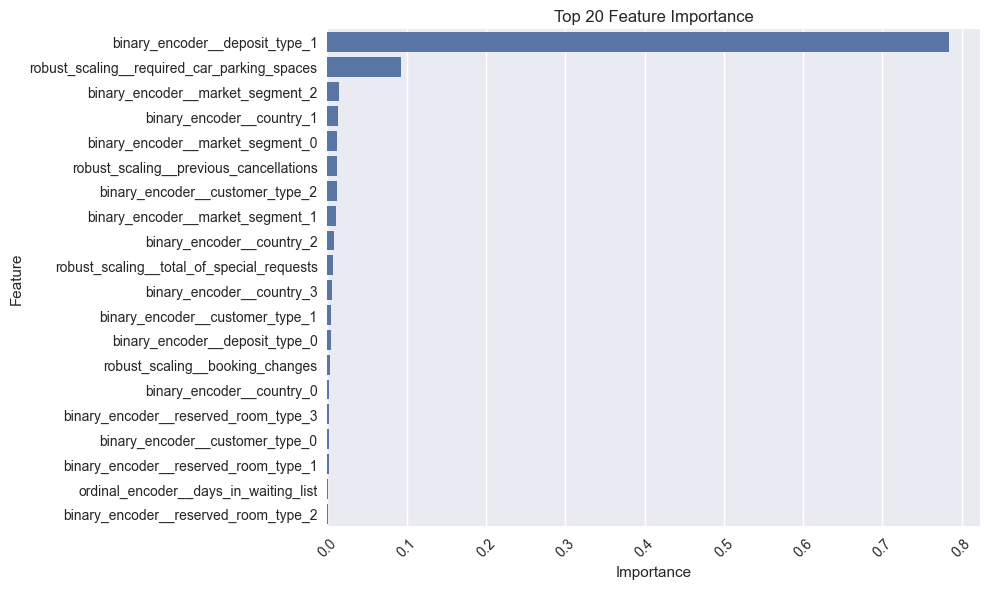


Feature Importance:
                                        Feature  Importance
9                binary_encoder__deposit_type_1    0.783755
19  robust_scaling__required_car_parking_spaces    0.092335
7              binary_encoder__market_segment_2    0.014635
2                     binary_encoder__country_1    0.013609
5              binary_encoder__market_segment_0    0.012812
17       robust_scaling__previous_cancellations    0.012665
12              binary_encoder__customer_type_2    0.012290
6              binary_encoder__market_segment_1    0.011087
3                     binary_encoder__country_2    0.008427
20    robust_scaling__total_of_special_requests    0.007738
4                     binary_encoder__country_3    0.005516
11              binary_encoder__customer_type_1    0.005115
8                binary_encoder__deposit_type_0    0.004913
18              robust_scaling__booking_changes    0.003187
1                     binary_encoder__country_0    0.002587
16         binary_e

In [35]:
# Dapatkan nama fitur setelah preprocessing
feature_names = transformer.get_feature_names_out()

# Dapatkan fitur-fitur penting dari model XGBoost
importance = pipe_model.named_steps['model'].feature_importances_

# Membuat DataFrame dari fitur yang penting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print feature importance
print("\nFeature Importance:")
print(feature_importance_df)

Peringkat Feature Importance mengungkapkan bahwa faktor paling signifikan yang mempengaruhi prediksi model adalah:

1. Jenis deposito (`deposit_type_1`)
2. Jumlah ruang parkir mobil yang dibutuhkan (`required_car_parking_spaces`)
3. Segmen pasar (`market_segment_2` & `market_segment_0`)
4. Negara (`country_1`)

Fitur-fitur lain, seperti jumlah total permintaan khusus, pembatalan sebelumnya, perubahan pemesanan, jenis pelanggan, dan hari dalam daftar tunggu, memiliki dampak yang relatif lebih kecil pada keputusan model.

## Confusion Matrix

Terakhir akan ditampilkan Confusion Matrix untuk menghitung biaya.

Confusion Matrix adalah tabel pengukuran kinerja yang merangkum hasil prediksi dari model klasifikasi dengan menunjukkan jumlah True Positive, True Negative, False Positive, dan False Negative.

### a. Confusion Matrix Model Sebelum Tuning

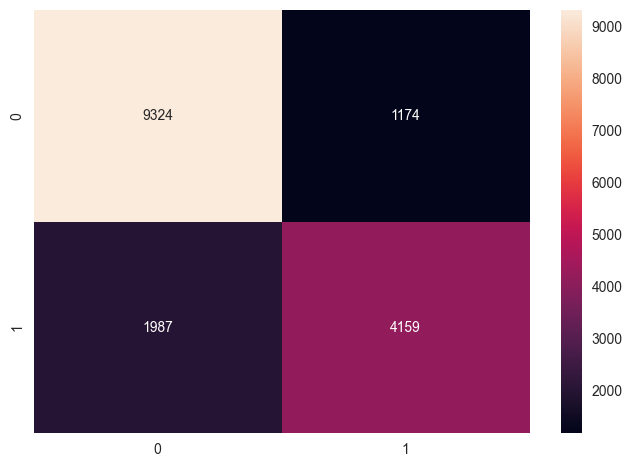

In [36]:
# Model sebelum tuning
sns.heatmap(confusion_matrix(y_test, y_pred_benchmark), annot=True, fmt='g');

### b. Confusion Matrix Model Setelah Tuning

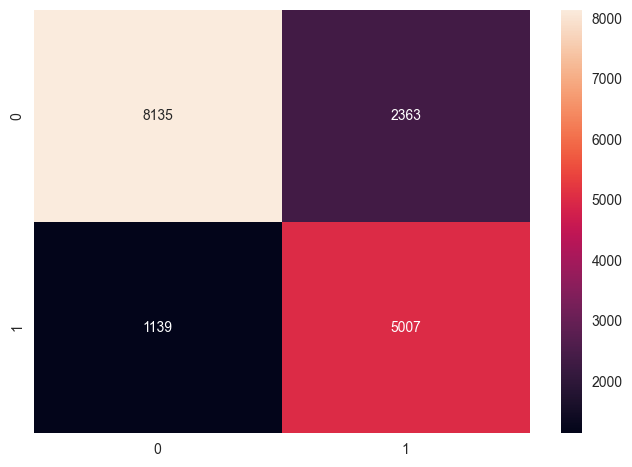

In [37]:
# Model setelah tuning
sns.heatmap(confusion_matrix(y_test, y_best_pipe), annot=True, fmt='g');

## Biaya Kerugian

Berdasarkan Confusion Matrix, maka akan dilakukan perhitungan kerugian apabila menggunakan model sebelum dituning dan setelah dituning.

In [38]:
def summarize_loss(confusion_matrix, fp_cost, fn_cost):
    tn, fp = confusion_matrix[0]
    fn, tp = confusion_matrix[1]
    
    total_samples = tn + fp + fn + tp
    total_fp_cost = fp * fp_cost
    total_fn_cost = fn * fn_cost
    total_cost = total_fp_cost + total_fn_cost
    
    summary = f"""
    ---Rangkuman Kerugian---

        Total Sampel: {total_samples}
        Biaya Total False Positive: €{total_fp_cost:,.2f}
        Biaya Total False Negative: €{total_fn_cost:,.2f}
        Biaya Total: €{total_cost:,.2f}
        Rata-rata biaya per sampel: €{total_cost/total_samples:.2f}
        
    ---------------
    """
    
    return summary

### a. Biaya Kerugian Model Sebelum Tuning

In [39]:
print(summarize_loss(confusion_matrix(y_test, y_pred_benchmark), 211, 442))


    ---Rangkuman Kerugian---

        Total Sampel: 16644
        Biaya Total False Positive: €247,714.00
        Biaya Total False Negative: €878,254.00
        Biaya Total: €1,125,968.00
        Rata-rata biaya per sampel: €67.65
        
    ---------------
    


### b. Biaya Kerugian Model Setelah Tuning

In [40]:
print(summarize_loss(confusion_matrix(y_test, y_best_pipe), 211, 442))


    ---Rangkuman Kerugian---

        Total Sampel: 16644
        Biaya Total False Positive: €498,593.00
        Biaya Total False Negative: €503,438.00
        Biaya Total: €1,002,031.00
        Rata-rata biaya per sampel: €60.20
        
    ---------------
    


Dapat dilakukan perhitungan:
- Penghematan = €1,125,968.00 - €1,002,031.00 = €123,937.00
- Persentase Penghematan = (123,937/1,125,968) × 100 = 11%

Dengan menggunakan model setelah dituning, maka akan menghemat biaya sebesar €123,937.00 atau 11%.

## Limitasi Model

Model yang diterapkan memiliki beberapa keterbatasan, yaitu: 
- Model ini bergantung pada historical data, yang mungkin tidak dapat menyesuaikan dengan tren baru atau kejadian tak terduga. Bias dalam data training dapat terbawa ke dalam predictions, yang berpotensi menghasilkan hasil yang tidak adil. Model ini juga terbatas pada ranges yang didefinisikan dalam dataset dan kurang reliable ketika kombinasi fitur tidak well-represented dalam data training.
- Model ini mengasumsikan konsistensi data input; kinerjanya dapat menurun jika data distributions berubah dari waktu ke waktu. Complex architectures juga dapat membatasi interpretability, sehingga mengurangi trust dan transparency. Scalability dan latency juga dapat terpengaruh oleh resource constraints dalam production.
- Regular monitoring dan retraining sangat penting untuk menjaga accuracy dan menyesuaikan dengan perubahan pada data atau context.

## Conclusion

In [41]:
confusion_matrix(y_test, y_best_pipe)

array([[8135, 2363],
       [1139, 5007]], dtype=int64)

In [42]:
print('Classification Report XGBoost Setelah Tuning: \n', classification_report(y_test, y_best_pipe))

Classification Report XGBoost Setelah Tuning: 
               precision    recall  f1-score   support

           0       0.88      0.77      0.82     10498
           1       0.68      0.81      0.74      6146

    accuracy                           0.79     16644
   macro avg       0.78      0.79      0.78     16644
weighted avg       0.80      0.79      0.79     16644



In [43]:
# Asumsi Jumlah Tamu Hotel Suatu Waktu Yang Melakukan Pembatalan dan Tidak
y_test.value_counts()

is_canceled
0    10498
1     6146
Name: count, dtype: int64

Berdasarkan nilai Recall yang telah kita dapatkan, dapat ditarik kesimpulan bahwasannya seandainya model digunakan untuk mengetahui tamu hotel yang akan melakukan pembatalan atau tidak, maka: 
- Dari semua pembatalan yang benaran terjadi, model ini dapat mengidentifikasi dengan benar 81% di antaranya.
- Dari semua pemesanan yang tidak dibatalkan, model ini dapat mengidentifikasi dengan benar 77% di antaranya.

Misal pada suatu waktu jumlah tamu hotel sebesar 16,644 orang, maka perhitungan tanpa menggunakan model dan menggunakan model sebagai berikut: <br>

Tanpa model:<br>
- Jika diprediksi bahwasannya semua tamu hotel tidak melakukan pembatalan, maka nantinya akan kehilangan pembatalan yang benar-benar terjadi.
- False Negatives = 6,146 kasus × €442
- Total Biaya Kerugian Tanpa Model = €2,716,532

Dengan model:
- Biaya False Negative:<br>
1,139 kasus × €442 = €503,438
- Biaya False Positive:<br>
2,363 kasus × €211 = €498,593
- Total Biaya Kerugian with Model:<br>
€503,438 + €498,593 = €1,002,031

Maka berdasarkan hasil perhitungan di atas, dengan menggunakan model yang telah dibuat maka Hotel dapat menghemat biaya lebih dari 2 kali lipat dibandingkan tanpa menggunakan model.

## Recommendation

Berikut merupakan saran untuk mempermudah pengembangan model menjadi lebih baik:
1. Menambahkan banyak fitur data tamu hotel (cth. `unique_id`, `waktu_kedatangan`) pada pengisian data tamu hotel.
2. Mencoba algoritma-algoritma ML yang belum dicoba, dan juga mencoba resampling data yang lain selain bawaan dari XGBoost, seperti ROS, RUS, dan SMOTE.
3. Menganalisis data-data yang mengalami misprediksi untuk mengetahui penyimpangan dan mengidentifikasi area perbaikan model.

In [44]:
import pickle
with open('hotel_booking_prediction_model.sav', 'wb') as file:
    pickle.dump(best_model_pipe, file)